# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [5]:
 # define your regions here
presel = {
    
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )", 
#             "lep_fj_dr": "( ( lep_fj_dr<0.8) )",   
            
            ### signal region
#             "LepIsolation": " ( (lep_pt<55) & (lep_isolation<0.15) ) | (lep_pt>=55)",
#             "LepMisolation": " ( (lep_pt>=55) & (lep_misolation<0.2) ) | (lep_pt<55)",
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#             "lep_fj_dr": "( ( lep_fj_dr<0.8) )",               
            ### signal region
#             "LepIsolation": " ( (lep_pt<120) & (lep_isolation<0.15) ) | (lep_pt>=120)",
        },
}

samples_dir = {
    "2016":    "../eos/postprocessOct13_hidNeurons_2016",
    "2016APV": "../eos/postprocessOct13_hidNeurons_2016APV",    
    "2017":    "../eos/postprocessOct9_hidNeurons_2017",
    "2018":    "../eos/postprocessOct5_hidNeurons_2018",
}

In [6]:
from make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2017", "2018"]

events_dict = {}
events_dict["signal_region"] = {}
events_dict["qcd_region"] = {}
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
    events_dict["signal_region"] = {**events_dict["signal_region"], **out}
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="qcd_region")
    events_dict["qcd_region"] = {**events_dict["qcd_region"], **out}

INFO:root:Finding DYJetsToLL_M-50_HT-600to800 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 165029 events
INFO:root:Will fill the DYJets dataframe with the remaining 165029 events
INFO:root:tot event weight 3057.8149388615484 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3841 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3841 events
INFO:root:tot event weight 6124.89967450774 

INFO:root:Finding DYJetsToLL_M-10to50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 362 events
INFO:root:Will fill the DYJets dataframe with the remaining 362 events
INFO:root:tot event weight 6294.187524951826 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine 

INFO:root:Will fill the WJetsLNu dataframe with the remaining 166 events
INFO:root:tot event weight 289.69795840326003 

INFO:root:Finding SingleMuon_Run2017C samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017C
INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 27132 events
INFO:root:Will fill the SingleTop dataframe with the remaining 27132 events
INFO:root:tot event weight 90.69283597942014 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017D
INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 20199 events
INFO:root:Will fill the DYJets dataframe with the remaining 20199 events
INFO:root:tot event weight 3209.1

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 57465 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 57465 events
INFO:root:tot event weight 71.17365548664372 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 11238 events
INFO:root:Will fill the ttH dataframe with the remaining 11238 events
INFO:root:tot event weight 39.50339569654196 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1308 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1308 events
INFO:root:tot event weight 103.37385465732507 

INFO:root:Finding SingleElectron_Run2017F samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 137982 events
INFO:root:Will fill the Data dat

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 138315 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 138315 events
INFO:root:tot event weight 67457.97977424678 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 11206 events
INFO:root:Will fill the SingleTop dataframe with the remaining 11206 events
INFO:root:tot event weight 2582.080510774146 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 17893 events
INFO:root:Will fill the ggF dataframe with the remaining 17893 events
INFO:root:tot event weight 147.14511546667495 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:r

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 9478 events
INFO:root:Will fill the Diboson dataframe with the remaining 9478 events
INFO:root:tot event weight 0.08743811300908065 

INFO:root:Finding DYJetsToLL_M-50_HT-2500toInf samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 38007 events
INFO:root:Will fill the DYJets dataframe with the remaining 38007 events
INFO:root:tot event weight 5.579411705979712 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1477 events
INFO:root:Will fill the QCD dataframe with the remaining 1477 events
INFO:root:tot event weight 24.665749862048806 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selecti

INFO:root:Will fill the WJetsLNu dataframe with the remaining 3524 events
INFO:root:tot event weight 5630.655633688352 

INFO:root:Finding DYJetsToLL_M-10to50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 231 events
INFO:root:Will fill the DYJets dataframe with the remaining 231 events
INFO:root:tot event weight 4058.262245381263 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 104301 events
INFO:root:Will fill the DYJets dataframe with the remaining 104301 events
INFO:root:tot event weight 970.9149093445114 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 512 events
INFO:root:Will fill the VBF dataframe with the remaining 512 ev

INFO:root:tot event weight 36.0789518120401 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017D
INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1992 events
INFO:root:Will fill the DYJets dataframe with the remaining 1992 events
INFO:root:tot event weight 196.84062456098883 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 817 events
INFO:root:Will fill the QCD dataframe with the remaining 817 events
INFO:root:tot event weight 0.5600951131483085 

INFO:root:Finding SingleMuon_Run2017E samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017E
INFO:root:Finding SingleMuon_Run2017B samples and should combine them under Data
INFO:ro

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1256 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1256 events
INFO:root:tot event weight 100.37234402438713 

INFO:root:Finding SingleElectron_Run2017F samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 89435 events
INFO:root:Will fill the Data dataframe with the remaining 89435 events
INFO:root:tot event weight 89435.0 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2285 events
INFO:root:Will fill the QCD dataframe with the remaining 2285 events
INFO:root:tot event weight 129.36898491719404 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 227 events
INFO:root:Will fill the WZQQ dataframe with the r

INFO:root:tot event weight 13.465640694069142 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 36 events
INFO:root:Will fill the WZQQ dataframe with the remaining 36 events
INFO:root:tot event weight 337.534260562948 

INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1558 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1558 events
INFO:root:tot event weight 350.6929888484839 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 34 events
INFO:root:Will fill the WZQQ dataframe with the remaining 34 events
INFO:root:tot event weight 141.2438913103938 

INFO:root:Finding SingleElectro

INFO:root:tot event weight 638.5551203762068 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 32845 events
INFO:root:Will fill the QCD dataframe with the remaining 32845 events
INFO:root:tot event weight 10647.044888606399 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 17686 events
INFO:root:Will fill the QCD dataframe with the remaining 17686 events
INFO:root:tot event weight 241568.68373560853 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 27330 events
INFO:root:Will fill the WZQQ dataframe with the remaining 27330 events
INFO:root:tot event weight 2835.4523282334117 

INFO:root:Finding DYJetsToLL_M-50_HT-1200to2500 sam

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 452 events
INFO:root:Will fill the VBF dataframe with the remaining 452 events
INFO:root:tot event weight 16.62353241765953 

INFO:root:Finding SingleMuon_Run2016G samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2016G
INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4676 events
INFO:root:Will fill the VH dataframe with the remaining 4676 events
INFO:root:tot event weight 2.817210677547452 

INFO:root:Finding DYJetsToLL_M-50_HT-70to100 samples and should combine them under DYJets
INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 63781 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 63781 eve

INFO:root:tot event weight 307.91992267796627 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 290084 events
INFO:root:Will fill the TTbar dataframe with the remaining 290084 events
INFO:root:tot event weight 8075.778985908838 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 576 events
INFO:root:Will fill the QCD dataframe with the remaining 576 events
INFO:root:tot event weight 0.018203047770200695 

INFO:root:Finding DYJetsToLL_Pt-650ToInf samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 111315 events
INFO:root:Will fill the DYJets dataframe with the remaining 111315 events
INFO:root:tot event weight 40.88013980601427 

INFO:root:Finding GluGluHToTauTau samples and

INFO:root:Finding WZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1724 events
INFO:root:Will fill the Diboson dataframe with the remaining 1724 events
INFO:root:tot event weight 102.77453335409692 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1903 events
INFO:root:Will fill the QCD dataframe with the remaining 1903 events
INFO:root:tot event weight 1.9487176207843764 

INFO:root:Finding DYJetsToLL_M-50_HT-200to400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 12045 events
INFO:root:Will fill the DYJets dataframe with the remaining 12045 events
INFO:root:tot event weight 7172.258878328936 

INFO:root:Finding DYJetsToLL_Pt-100To250 samples and should combine them under DYJets
INFO:root:

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 93 events
INFO:root:Will fill the QCD dataframe with the remaining 93 events
INFO:root:tot event weight 0.00022342759181511777 

INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6836 events
INFO:root:Will fill the VH dataframe with the remaining 6836 events
INFO:root:tot event weight 6.647082908278545 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 70 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 70 events
INFO:root:tot event weight 125.46291439082975 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr se

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 48459 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 48459 events
INFO:root:tot event weight 39.44400714172126 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 10484 events
INFO:root:Will fill the ttH dataframe with the remaining 10484 events
INFO:root:tot event weight 15.24750767439187 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 782 events
INFO:root:Will fill the WZQQ dataframe with the remaining 782 events
INFO:root:tot event weight 43.33308588125892 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2970 eve

INFO:root:Will fill the SingleTop dataframe with the remaining 2974 events
INFO:root:tot event weight 652.2776772111371 

INFO:root:Finding SingleElectron_Run2016H samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 57745 events
INFO:root:Will fill the Data dataframe with the remaining 57745 events
INFO:root:tot event weight 57745.0 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3515 events
INFO:root:Will fill the ggF dataframe with the remaining 3515 events
INFO:root:tot event weight 25.662457973116997 

INFO:root:Finding SingleElectron_Run2016F samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 2855 events
INFO:root:Will fill the Data dataframe with the remaining 2855 events
INFO:root:tot event weight 2855.0 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them und

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4200 events
INFO:root:Will fill the QCD dataframe with the remaining 4200 events
INFO:root:tot event weight 8709.92726580321 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1042 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1042 events
INFO:root:tot event weight 105.11165349265539 

INFO:root:Finding DYJetsToLL_M-50_HT-1200to2500 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 61220 events
INFO:root:Will fill the DYJets dataframe with the remaining 61220 events
INFO:root:tot event weight 136.33072715413363 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
I

INFO:root:Will fill the VH dataframe with the remaining 619 events
INFO:root:tot event weight 0.3645103590311303 

INFO:root:Finding DYJetsToLL_M-50_HT-70to100 samples and should combine them under DYJets
INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6389 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6389 events
INFO:root:tot event weight 349.99242788848994 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 7228 events
INFO:root:Will fill the TTbar dataframe with the remaining 7228 events
INFO:root:tot event weight 3029.9966207387843 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2016G
INFO:root:Finding DYJetsToLL_Pt-250To400 

INFO:root:Will fill the DYJets dataframe with the remaining 1610 events
INFO:root:tot event weight 0.6266632067674786 

INFO:root:Finding GluGluHToTauTau samples and should combine them under HTauTau
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6 events
INFO:root:Will fill the HTauTau dataframe with the remaining 6 events
INFO:root:tot event weight 0.05889779548413631 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3054 events
INFO:root:Will fill the WZQQ dataframe with the remaining 3054 events
INFO:root:tot event weight 1051.8010662781621 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 80 events
INFO:root:Will fill the Diboson dataframe with the remaining 80 events
INFO:root:tot event weight 14.95412090

INFO:root:tot event weight 167.89521423384326 

INFO:root:Finding DYJetsToLL_Pt-100To250 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4810 events
INFO:root:Will fill the DYJets dataframe with the remaining 4810 events
INFO:root:tot event weight 99.14593161436176 

INFO:root:Finding DYJetsToLL_M-50_HT-600to800 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 10074 events
INFO:root:Will fill the DYJets dataframe with the remaining 10074 events
INFO:root:tot event weight 1399.8698220235951 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1272 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1272 events
INFO:root:tot event weight 1988.8941148122237 

INFO:root:Findi

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 11010 events
INFO:root:Will fill the DYJets dataframe with the remaining 11010 events
INFO:root:tot event weight 1399.2228568204314 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 946 events
INFO:root:Will fill the QCD dataframe with the remaining 946 events
INFO:root:tot event weight 0.29476047651253073 

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3472 events
INFO:root:Will fill the Diboson dataframe with the remaining 3472 events
INFO:root:tot event weight 344.01834398009646 

INFO:root:Finding SingleMuon_Run2016D_HIPM samples and should combine them under Data
INFO:root:No par

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 36148 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 36148 events
INFO:root:tot event weight 29.27838573936966 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 8732 events
INFO:root:Will fill the ttH dataframe with the remaining 8732 events
INFO:root:tot event weight 16.32351368466015 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 518 events
INFO:root:Will fill the WZQQ dataframe with the remaining 518 events
INFO:root:tot event weight 44.45460572127105 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4416 event

INFO:root:Will fill the WJetsLNu dataframe with the remaining 52559 events
INFO:root:tot event weight 27326.64681781931 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4494 events
INFO:root:Will fill the SingleTop dataframe with the remaining 4494 events
INFO:root:tot event weight 1161.0601102915246 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 9531 events
INFO:root:Will fill the ggF dataframe with the remaining 9531 events
INFO:root:tot event weight 64.63722071486438 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1 event

INFO:root:tot event weight 11.315214510473464 

INFO:root:Finding SingleElectron_Run2016D_HIPM samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2016D_HIPM
INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3829 events
INFO:root:Will fill the QCD dataframe with the remaining 3829 events
INFO:root:tot event weight 196.77491853630684 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2414 events
INFO:root:Will fill the QCD dataframe with the remaining 2414 events
INFO:root:tot event weight 5536.46803740602 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 890 events
INFO:root:Will fill the WZQQ

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 106981 events
INFO:root:Will fill the DYJets dataframe with the remaining 106981 events
INFO:root:tot event weight 445.0794711056727 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 244 events
INFO:root:Will fill the VBF dataframe with the remaining 244 events
INFO:root:tot event weight 10.232673626382839 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2496 events
INFO:root:Will fill the VH dataframe with the remaining 2496 events
INFO:root:tot event weight 1.8786630673188829 

INFO:root:Finding DYJetsToLL_M-50_HT-70to100 samples and should combine 

INFO:root:No parquet file for SingleMuon_Run2016D_HIPM
INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3890 events
INFO:root:Will fill the SingleTop dataframe with the remaining 3890 events
INFO:root:tot event weight 128.53536840249498 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 110633 events
INFO:root:Will fill the TTbar dataframe with the remaining 110633 events
INFO:root:tot event weight 4038.7750576018643 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 572 events
INFO:root:Will fill the QCD dataframe with the remaining 572 events
INFO:root:tot event weight 0.01881166783938846 

INFO:root:Finding 

INFO:root:Applying lep_fj_dr selection on 4007 events
INFO:root:Will fill the QCD dataframe with the remaining 4007 events
INFO:root:tot event weight 55.940417437816414 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 260 events
INFO:root:Will fill the WZQQ dataframe with the remaining 260 events
INFO:root:tot event weight 236.46325508708196 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 15519 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 15519 events
INFO:root:tot event weight 7578.46183279837 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4469 events
INFO:root:Will fill the QCD datafra

INFO:root:Applying lep_fj_dr selection on 803 events
INFO:root:Will fill the SingleTop dataframe with the remaining 803 events
INFO:root:tot event weight 207.87779352226525 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 22 events
INFO:root:Will fill the WZQQ dataframe with the remaining 22 events
INFO:root:tot event weight 70.7399912153908 

INFO:root:Finding DYJetsToLL_M-50_HT-800to1200 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3386 events
INFO:root:Will fill the DYJets dataframe with the remaining 3386 events
INFO:root:tot event weight 30.352201337872394 

INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2470 events
INFO:root:Will fill the QCD data

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 11210 events
INFO:root:Will fill the WZQQ dataframe with the remaining 11210 events
INFO:root:tot event weight 1082.2237043798477 

INFO:root:Finding SingleMuon_Run2016B_ver2_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 252116 events
INFO:root:Will fill the Data dataframe with the remaining 252116 events
INFO:root:tot event weight 252116.0 

INFO:root:Finding SingleMuon_Run2016E_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 184384 events
INFO:root:Will fill the Data dataframe with the remaining 184384 events
INFO:root:tot event weight 184384.0 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6424 events
INFO:r

INFO:root:No parquet file for .DS_Store
INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 200699 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 200699 events
INFO:root:tot event weight 11305.454004645097 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 739094 events
INFO:root:Will fill the TTbar dataframe with the remaining 739094 events
INFO:root:tot event weight 102736.52696127896 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 749616 events
INFO:root:Will fill the DYJets dataframe with the remaining 749616 events
INFO:root:tot event weight 7870.585976276841 

INFO:root:Finding ST_t-ch

INFO:root:Will fill the HTauTau dataframe with the remaining 1401 events
INFO:root:tot event weight 19.023391108478425 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 350 events
INFO:root:Will fill the WZQQ dataframe with the remaining 350 events
INFO:root:tot event weight 260.96182863793416 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 813 events
INFO:root:Will fill the Diboson dataframe with the remaining 813 events
INFO:root:tot event weight 163.24974776797114 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1854 events
INFO:root:Will fill the TTbar dataframe with the remaining 1854 events
INFO:root:tot event weight 323.60828292

INFO:root:Finding WZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1619 events
INFO:root:Will fill the Diboson dataframe with the remaining 1619 events
INFO:root:tot event weight 332.54866014134143 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1556 events
INFO:root:Will fill the QCD dataframe with the remaining 1556 events
INFO:root:tot event weight 5.425081797936674 

INFO:root:Finding DYJetsToLL_M-50_HT-200to400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 34765 events
INFO:root:Will fill the DYJets dataframe with the remaining 34765 events
INFO:root:tot event weight 22940.50340914644 

INFO:root:Finding DYJetsToLL_Pt-100To250 samples and should combine them under DYJets
INFO:root:-

INFO:root:Finding EGamma_Run2018A samples and should combine them under Data
INFO:root:No parquet file for EGamma_Run2018A
INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 223 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 223 events
INFO:root:tot event weight 392.9566780984253 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 44179 events
INFO:root:Will fill the SingleTop dataframe with the remaining 44179 events
INFO:root:tot event weight 153.71544294191725 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 19391 events
INFO:root:Will fill the DYJets dataframe with the remain

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 124286 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 124286 events
INFO:root:tot event weight 124.24205906574713 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 27886 events
INFO:root:Will fill the ttH dataframe with the remaining 27886 events
INFO:root:tot event weight 45.79212025696975 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1056 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1056 events
INFO:root:tot event weight 120.44179260169416 

INFO:root:Finding EGamma_Run2018C samples and should combine them under Data
INFO:root:No parquet file for EGamma_Run2018C
INFO:root:Finding EGamma_Run2018D samples and s

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 127 events
INFO:root:Will fill the SingleTop dataframe with the remaining 127 events
INFO:root:tot event weight 1.0357274863495263 

INFO:root:Finding DYJetsToLL_M-50_HT-400to600 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1084 events
INFO:root:Will fill the DYJets dataframe with the remaining 1084 events
INFO:root:tot event weight 6981.240178583848 

INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 144333 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 144333 events
INFO:root:tot event weight 2036.1524229921833 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:ro

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 36554 events
INFO:root:Will fill the DYJets dataframe with the remaining 36554 events
INFO:root:tot event weight 9.527570075882057 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2311 events
INFO:root:Will fill the QCD dataframe with the remaining 2311 events
INFO:root:tot event weight 51.84495114914267 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1813 events
INFO:root:Will fill the QCD dataframe with the remaining 1813 events
INFO:root:tot event weight 838.7085532087076 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1131 events
INFO:

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 715 events
INFO:root:Will fill the DYJets dataframe with the remaining 715 events
INFO:root:tot event weight 150.42788366430537 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 101 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 101 events
INFO:root:tot event weight 220.84266291467492 

INFO:root:Finding DYJetsToLL_M-10to50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 7 events
INFO:root:Will fill the DYJets dataframe with the remaining 7 events
INFO:root:tot event weight 833.6087642457901 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selec

INFO:root:tot event weight 10.314930321340091 

INFO:root:Finding SingleMuon_Run2018A samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 581724 events
INFO:root:Will fill the Data dataframe with the remaining 581724 events
INFO:root:tot event weight 581724.0 

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 465 events
INFO:root:Will fill the Diboson dataframe with the remaining 465 events
INFO:root:tot event weight 131.3304359765511 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 10346 events
INFO:root:Will fill the SingleTop dataframe with the remaining 10346 events
INFO:root:tot event weight 364.9498653059014 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:--

INFO:root:tot event weight 2679.947765637815 

INFO:root:Finding EGamma_Run2018B samples and should combine them under Data
INFO:root:No parquet file for EGamma_Run2018B
INFO:root:Finding SingleMuon_Run2018C samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 231556 events
INFO:root:Will fill the Data dataframe with the remaining 231556 events
INFO:root:tot event weight 231556.0 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1654 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1654 events
INFO:root:tot event weight 4913.098272979174 

INFO:root:Finding SingleMuon_Run2018D samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 1093263 events
INFO:root:Will fill the Data dataframe with the remaining 1093263 events
INFO:root:tot event weight 1093263.0 

INFO:root:Finding WJetsToLNu_H

In [7]:
events_dict.keys()

dict_keys(['signal_region', 'qcd_region'])

In [8]:
events_dict["signal_region"].keys()

dict_keys(['2017', '2016', '2016APV', '2018'])

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

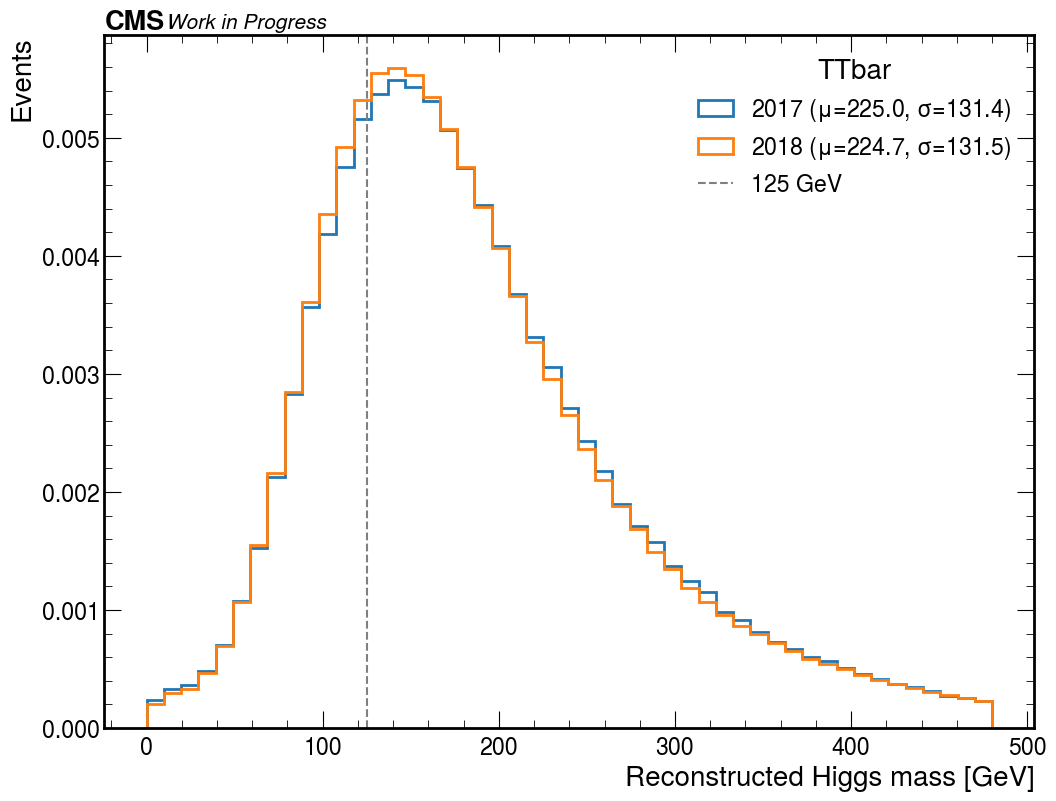

In [187]:
plt.rcParams.update({"font.size": 20})

bins = 50

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "TTbar"
channels = ["ele", "mu"]
region = "signal_region"

fig, ax = plt.subplots(figsize=(12, 9))

for year in ["2017", "2018"]:
        
    df1 = events_dict[region][year]["mu"][sample]    
    df2 = events_dict[region][year]["ele"][sample]

    df = pd.concat([df1, df2])
    
    x = df["rec_higgs_m"]
    w = df["event_weight"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=w,
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{year} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

# hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")        

In [11]:
# tagger_cuts = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8]
# tagger_cuts = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]
# tagger_cuts = np.linspace(0.7, 0.97, 28)

# tagger_cuts = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99]
# tagger_cuts = [0.90, 0.925, 0.95, 0.975, 0.99]

tagger_cuts = np.linspace(0.9, 0.99, 19)
# tagger_cuts = np.linspace(0.9, 0.99, 19*2-1)
# tagger_cuts = np.linspace(0.2, 0.97, 30)
# tagger_cuts = np.linspace(0.1, 0.85, 25)

# wp = 0.85
mass_window = [50, 200]

years = ["2017", "2018", "2016", "2016APV"]
channels = ["ele", "mu"]

s_over_b = {}

for tagger in [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_HPO",

    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:

        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict["signal_region"][year][ch]:
                    df = events_dict["signal_region"][year][ch][sample]

                    # add tagger cut
                    df = df[df[tagger]>tagger_cut]
                    # add mass window
                    df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                    # remove high weight events
                    df = df[df["event_weight"]<145]

                    # add inverted tagger cut
#                     df = df[df[tagger]<wp]

                    ##############################    
                    if "WJets" in sample:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.9
tagger cut 0.905
tagger cut 0.91
tagger cut 0.915
tagger cut 0.92
tagger cut 0.925
tagger cut 0.93
tagger cut 0.935
tagger cut 0.9400000000000001
tagger cut 0.9450000000000001
tagger cut 0.95
tagger cut 0.955
tagger cut 0.96
tagger cut 0.965
tagger cut 0.97
tagger cut 0.975
tagger cut 0.98
tagger cut 0.985
tagger cut 0.99
TAGGER: fj_ParT_score_finetuned_v2_nor2
tagger cut 0.9
tagger cut 0.905
tagger cut 0.91
tagger cut 0.915
tagger cut 0.92
tagger cut 0.925
tagger cut 0.93
tagger cut 0.935
tagger cut 0.9400000000000001
tagger cut 0.9450000000000001
tagger cut 0.95
tagger cut 0.955
tagger cut 0.96
tagger cut 0.965
tagger cut 0.97
tagger cut 0.975
tagger cut 0.98
tagger cut 0.985
tagger cut 0.99


In [19]:
# tagger_cuts = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8]
# tagger_cuts = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


# tagger_cuts = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99]
# tagger_cuts = [0.90, 0.925, 0.95, 0.975, 0.99]

# tagger_cuts = np.linspace(0.9, 0.99, 19)
tagger_cuts = np.linspace(0.7, 0.97, 28)
# tagger_cuts = np.linspace(0.1, 0.85, 25)

wp = 0.97
mass_window = [80, 160]

years = ["2017", "2018", "2016", "2016APV"]

channels = ["ele", "mu"]

s_over_b = {}

for tagger in [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_HPO",

    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:

        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict["signal_region"][year][ch]:
                    if sample=="Data":
                        continue
                        
                    df = events_dict["signal_region"][year][ch][sample]

                    # add tagger cut
                    df = df[df[tagger]>tagger_cut]
                    # add mass window
                    df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                    # remove high weight events
                    df = df[df["event_weight"]<145]

                    # add inverted tagger cut
                    df = df[df[tagger]<wp]

                    ##############################    
                    if sample in utils.signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.7
tagger cut 0.71
tagger cut 0.72
tagger cut 0.73
tagger cut 0.74
tagger cut 0.75
tagger cut 0.76
tagger cut 0.77
tagger cut 0.7799999999999999
tagger cut 0.7899999999999999
tagger cut 0.7999999999999999
tagger cut 0.8099999999999999
tagger cut 0.82
tagger cut 0.83
tagger cut 0.84
tagger cut 0.85
tagger cut 0.86
tagger cut 0.87
tagger cut 0.8799999999999999
tagger cut 0.8899999999999999
tagger cut 0.8999999999999999
tagger cut 0.9099999999999999
tagger cut 0.9199999999999999
tagger cut 0.9299999999999999
tagger cut 0.94
tagger cut 0.95
tagger cut 0.96
tagger cut 0.97


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_73990/3119391320.py:67: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b[tagger].append(s/math.sqrt(b))


TAGGER: fj_ParT_score_finetuned_v2_nor2
tagger cut 0.7
tagger cut 0.71
tagger cut 0.72
tagger cut 0.73
tagger cut 0.74
tagger cut 0.75
tagger cut 0.76
tagger cut 0.77
tagger cut 0.7799999999999999
tagger cut 0.7899999999999999
tagger cut 0.7999999999999999
tagger cut 0.8099999999999999
tagger cut 0.82
tagger cut 0.83
tagger cut 0.84
tagger cut 0.85
tagger cut 0.86
tagger cut 0.87
tagger cut 0.8799999999999999
tagger cut 0.8899999999999999
tagger cut 0.8999999999999999
tagger cut 0.9099999999999999
tagger cut 0.9199999999999999
tagger cut 0.9299999999999999
tagger cut 0.94
tagger cut 0.95
tagger cut 0.96
tagger cut 0.97


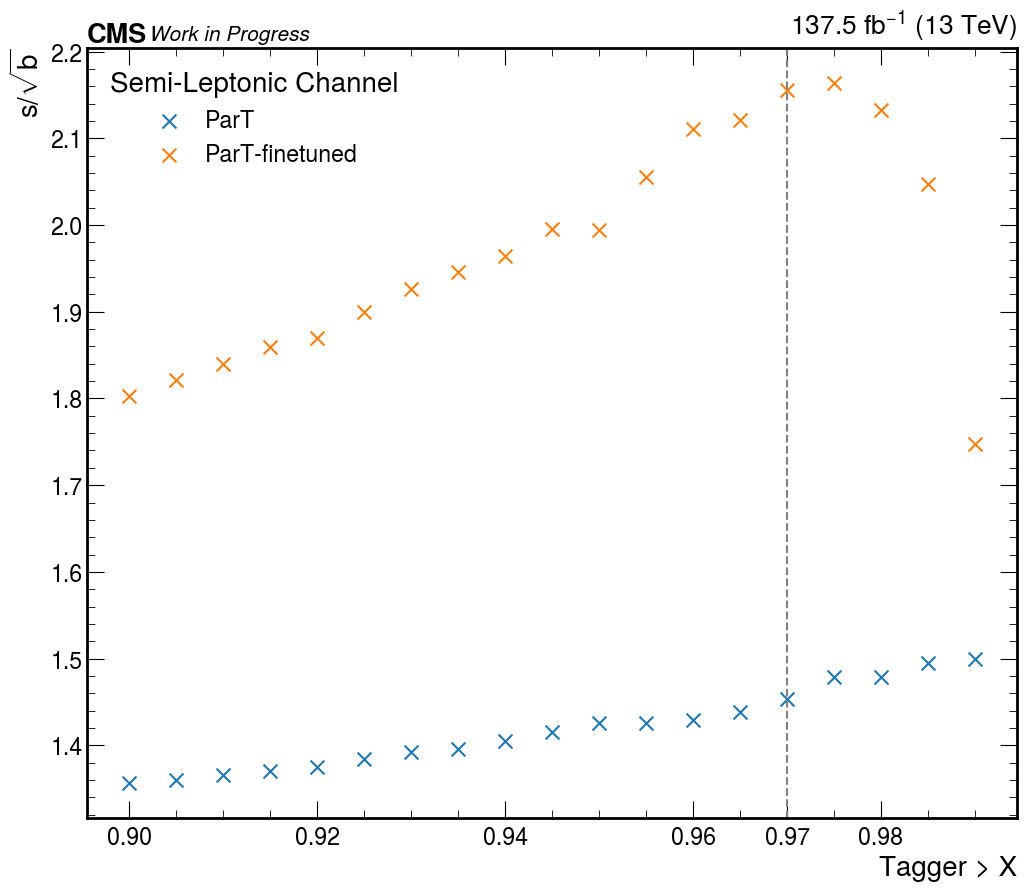

In [18]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",
    f"fj_ParT_score_finetuned_v2_nor2",
]:
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.97, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"$s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])


lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/soverb_high_signal_region.pdf")

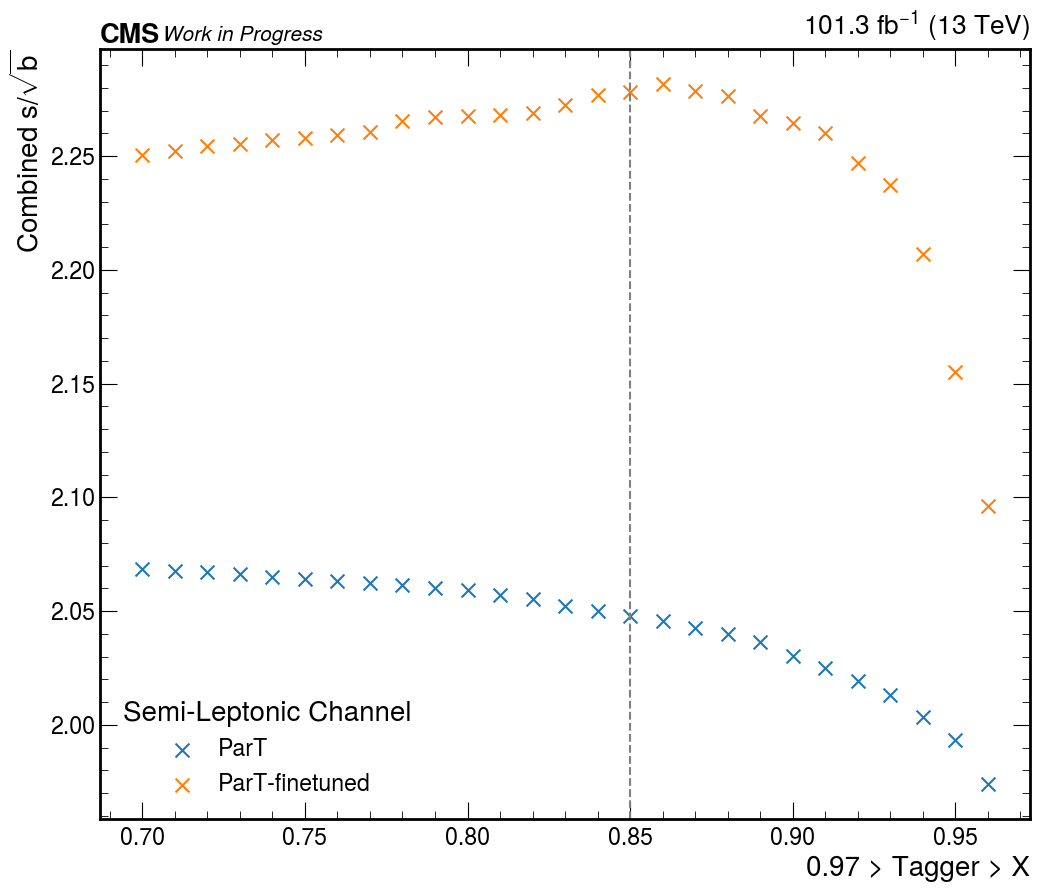

In [20]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))
years = ["2018", "2017"]


soverb_high = 1.95

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",
    f"fj_ParT_score_finetuned_v2_nor2",
]:
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.85, color="grey", linestyle="--")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"Combined $s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_medium_signal_region.pdf")

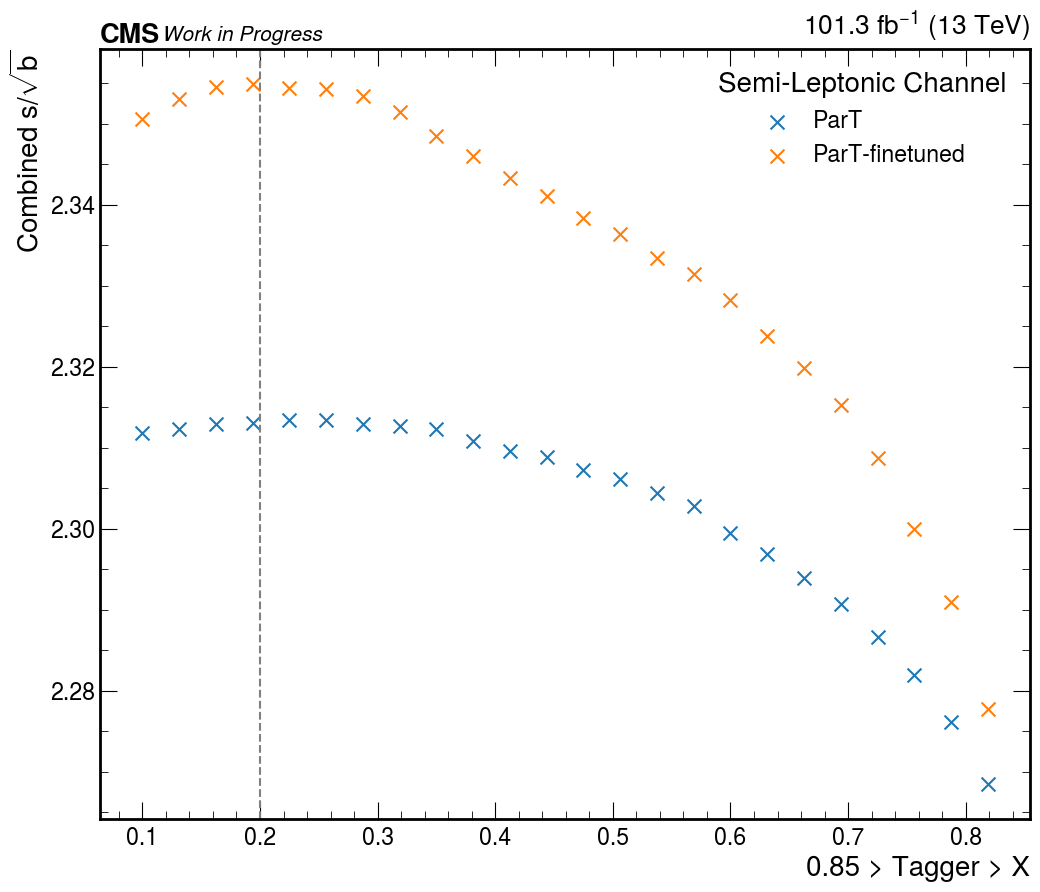

In [480]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))
years = ["2018", "2017"]


soverb_high = 2.26

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",


#         f"fj_ParT_score_finetuned_v2_10_5",
#         f"fj_ParT_score_finetuned_v2_10_12",   ### best: --start-lr 6.75e-3 --num-epochs 2500 norelu

#         f"fj_ParT_score_finetuned_v2_r1",
#         f"fj_ParT_score_finetuned_v2_r2",
#         f"fj_ParT_score_finetuned_v2_rs1",
#         f"fj_ParT_score_finetuned_v2_rs2",

#         f"fj_ParT_score_finetuned_v2_nor1",
    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.2, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"Combined $s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])


lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_low_signal_region.pdf")

# Stacked hists

In [9]:
vars_to_plot = [
#     "fj_minus_lep_m",
#     "fj_pt",
#     "lep_pt",
#     "fj_msoftdrop",
#     "fj_bjets_ophem",
#     "fj_bjets",
#     "lep_fj_dr",
#     "lep_met_mt",
#     "ht",
#     "met_fj_dphi",
#     "deta",
#     "met",
#     "mjj",
#     "fj_pt_over_lep_pt",
    "rec_higgs_m",
#     "rec_higgs_pt",
#     "rec_higgs_pt_over_lep_pt",    
#     "golden_var",
#     "rec_dphi_WW",
#     "fj_ParT_mass",
#     "fj_ParticleNet_mass"
#     "nj",
#     "inclusive_score",
#     "fj_ParT_score_finetuned_v2_10_12",
]

samples_to_plot = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]
# samples_to_plot = ["QCD"]

In [19]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
#     "tagger only": f"({tagger}<0.85) & ({tagger}>0.20)",   
#     "bjet only": f"n_bjets_L==0",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)"#" & (lep_fj_dr>0.3)",

}

categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) | (deta<3.5) ) & (fj_pt<300)",
    "ggF_pt300toinf": "( (mjj<1000) | (deta<3.5) ) & (fj_pt>300)",
}


channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

num, den = 0, 0
# fill histograms
hists = {}
for var in vars_to_plot:
            
    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
#         utils.axis_dict[var],
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                for k, v in presel.items():

                    if "QCD" in k:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]
                    
                    if "High" in k:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]
                    if "Medium" in k:
                        if sample == "QCD":
                            df = df[df["event_weight"]<200]
                    
                    df = df.query(v)

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

#                 if sample == "QCD":
#                     threshold = 100
                    
#                     den_ = len(df['event_weight'])
#                     df = df[df["event_weight"]<threshold]
#                     num_ = (den_ - len(df['event_weight']))
                    
#                     den += den_
#                     num += num_

                hists[var].fill(
                    samples=sample,
                    var=df[var],
                    weight=df["event_weight"],
                )     
# print(f"Removing {num} out of {den} qcd events by applying qcd event_weight<{threshold}")

Will plot rec_higgs_m histogram


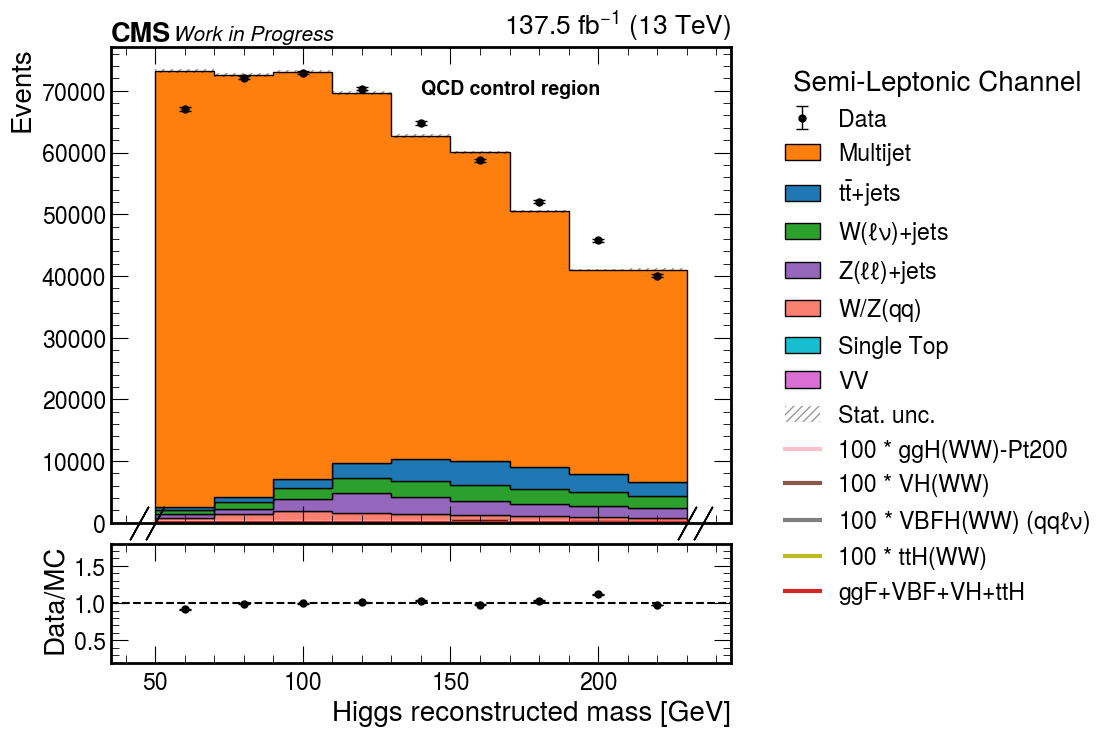

In [20]:
plt.rcParams.update({"font.size": 20})
from utils import plot_hists
plot_hists(years, channels, hists, vars_to_plot,             
            add_data=True,
            logy=False,
            add_soverb=False,
            only_sig=False,
            mult=100,
            outpath="/Users/fmokhtar/Desktop/farakikopku5/",
            text_=list(presel.keys())[0],           
#             text_=list(presel.keys())[0] + f"\n category: {list(categories_sel.keys())[0]}",
#             text_=list(presel.keys())[0] + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=list(presel.keys())[0] + f"\n Applying qcd event_weight<{threshold}",

#             blind_region=[90,150],
#            save_as=f"medium_{category}"
          )

In [1139]:
model = {}
model["Model 1"], model["Model 2"] = {}, {}

In [1022]:
# change epoch 5 and add epoch 19

model["Model 1"]["M"] = [1.01, 1.01, 0.99, 1.00, 1.00, 1.01, 1.00, 1.00, 1.00, 1.00, 1.00, 1.01, 1.01, 1.00, 1.00, 1.02, 1.01, 1.01, 1.01]
model["Model 1"]["IQR"] = [0.38, 0.34, 0.37, 0.36, 0.35, 0.35, 0.33, 0.35, 0.34, 0.35, 0.34, 0.33, 0.33, 0.32, 0.33, 0.36, 0.33, 0.33, 0.32] 
model["Model 1"]["fm"] = [0.13, 0.15, 0.14, 0.15, 0.15, 0.15, 0.16, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.15, 0.15, 0.16, 0.16]
 
model["Model 2"]["M"] = [1.05, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.03, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02]
model["Model 2"]["IQR"] = [0.43, 0.40, 0.37, 0.36, 0.36, 0.34, 0.34, 0.34, 0.33, 0.34, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.32, 0.32, 0.32]
model["Model 2"]["fm"] = [0.13, 0.14, 0.14, 0.15, 0.15, 0.16, 0.17, 0.16, 0.17, 0.17, 0.17, 0.18, 0.17, 0.18, 0.18, 0.17, 0.17, 0.17, 0.17, 0.18]

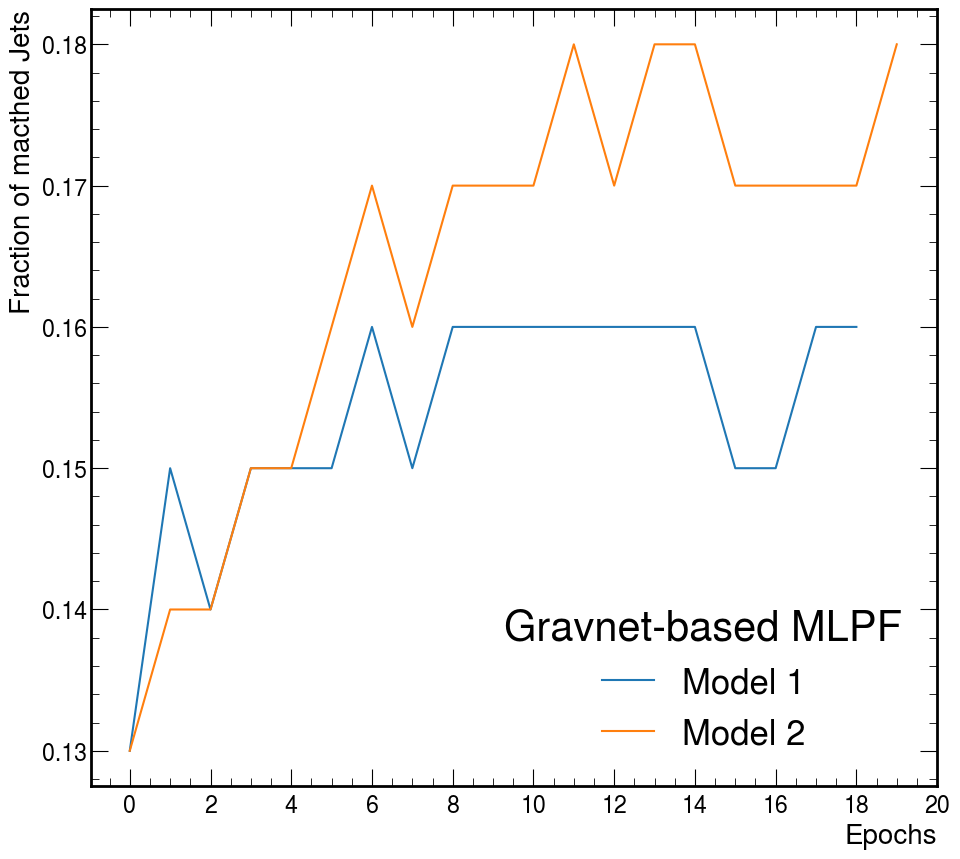

In [1023]:
fig, ax = plt.subplots(figsize=(10,9))

for m in ["Model 1", "Model 2"]:
    x = model[m]["fm"]
    ax.plot(x, label=m)

ax.set_xlabel("Epochs")
ax.set_ylabel(f"Fraction of macthed Jets")
ax.set_xticks([0,2,4,6,8,10,12,14,16,18, 20])
ax.legend(title="Gravnet-based MLPF", loc="best", title_fontsize=30, fontsize=25)
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/Jet_fm.pdf")

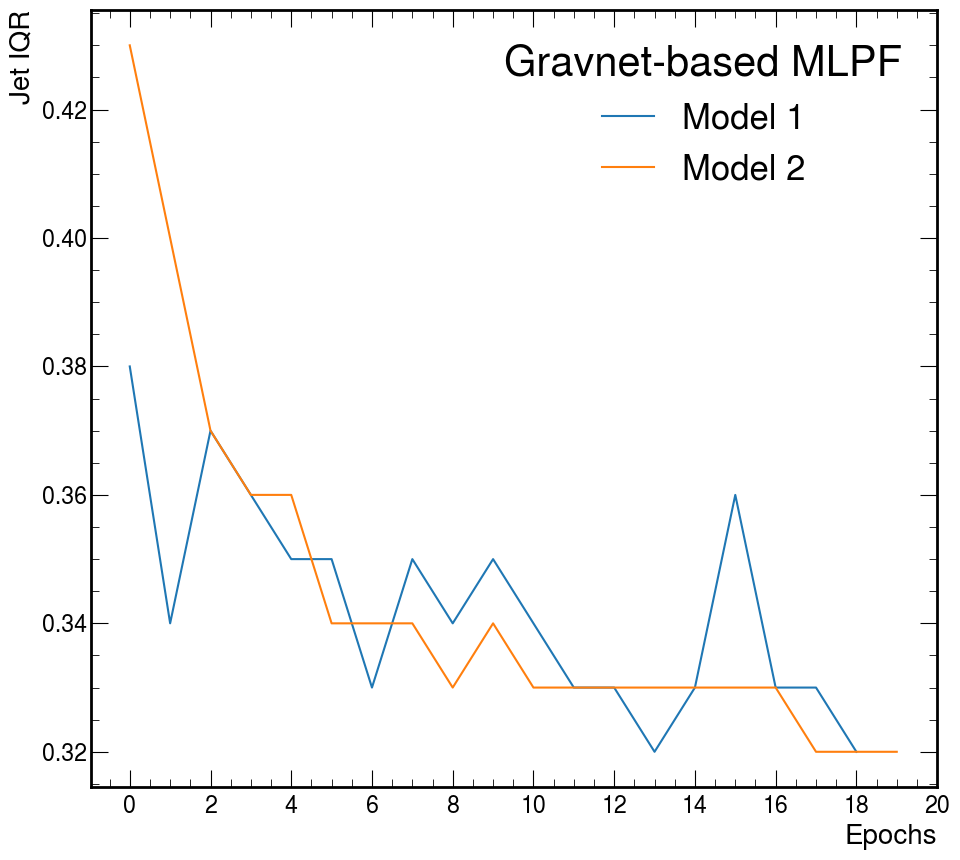

In [1024]:
fig, ax = plt.subplots(figsize=(10,9))


for m in ["Model 1", "Model 2"]:
    x = model[m]["IQR"]
    ax.plot(x, label=m)

ax.set_xlabel("Epochs")
ax.set_ylabel(f"Jet IQR")
ax.set_xticks([0,2,4,6,8,10,12,14,16,18, 20])
ax.legend(title="Gravnet-based MLPF", loc="best", title_fontsize=30, fontsize=25)
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/Jet_IQR.pdf")

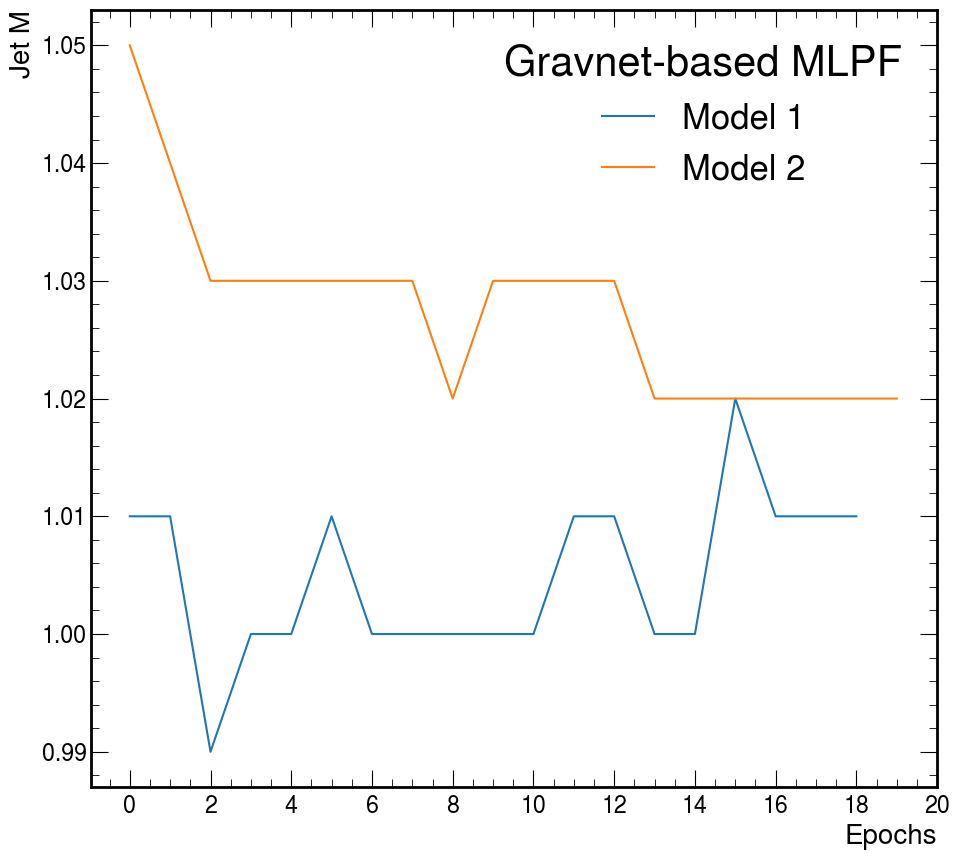

In [1025]:
fig, ax = plt.subplots(figsize=(10,9))


for m in ["Model 1", "Model 2"]:
    x = model[m]["M"]
    ax.plot(x, label=m)

ax.set_xlabel("Epochs")
ax.set_ylabel(f"Jet M")
ax.set_xticks([0,2,4,6,8,10,12,14,16,18, 20])
ax.legend(title="Gravnet-based MLPF", loc="best", title_fontsize=30, fontsize=25)
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/Jet_M.pdf")

In [891]:
! ls /Users/fmokhtar/Downloads/

mlpf_losses.pkl


In [997]:
import pickle as pkl
with open("/Users/fmokhtar/Downloads/mlpf_losses_1.pkl", "rb") as f:
    losses1 = pkl.load(f)
    
import pickle as pkl
with open("/Users/fmokhtar/Downloads/mlpf_losses_2.pkl", "rb") as f:
    losses2 = pkl.load(f)    

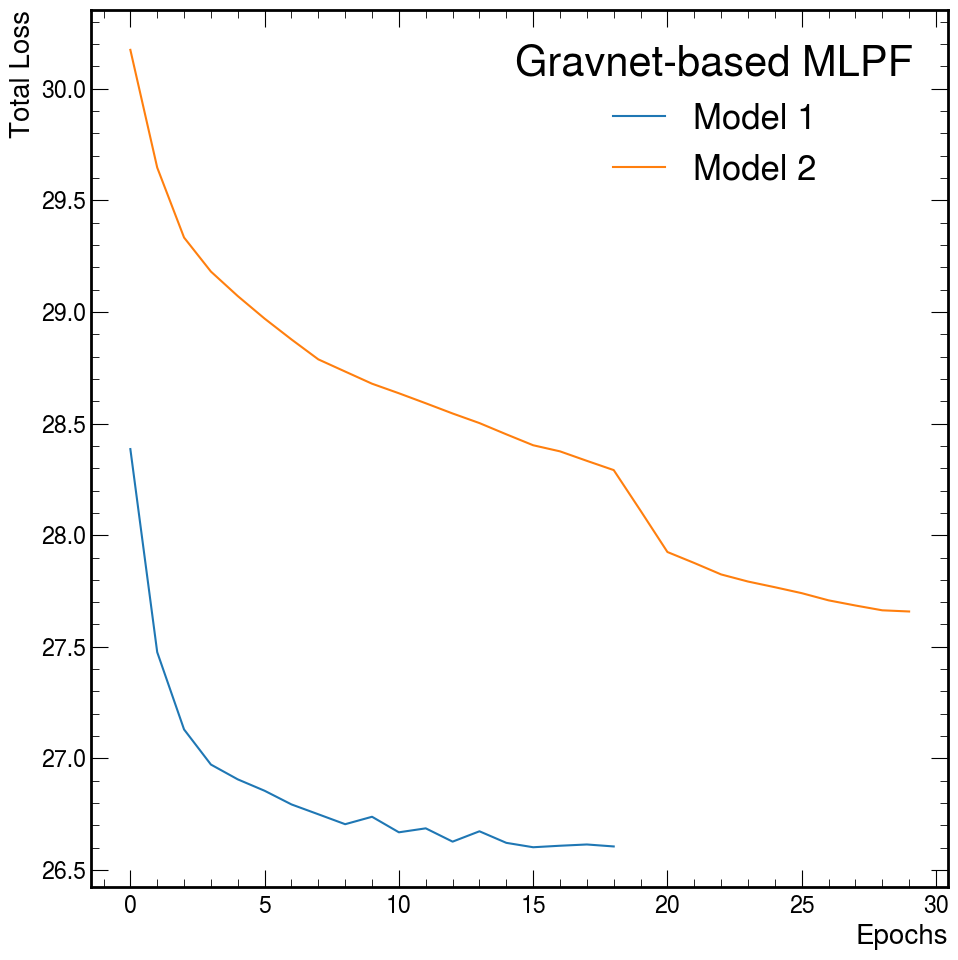

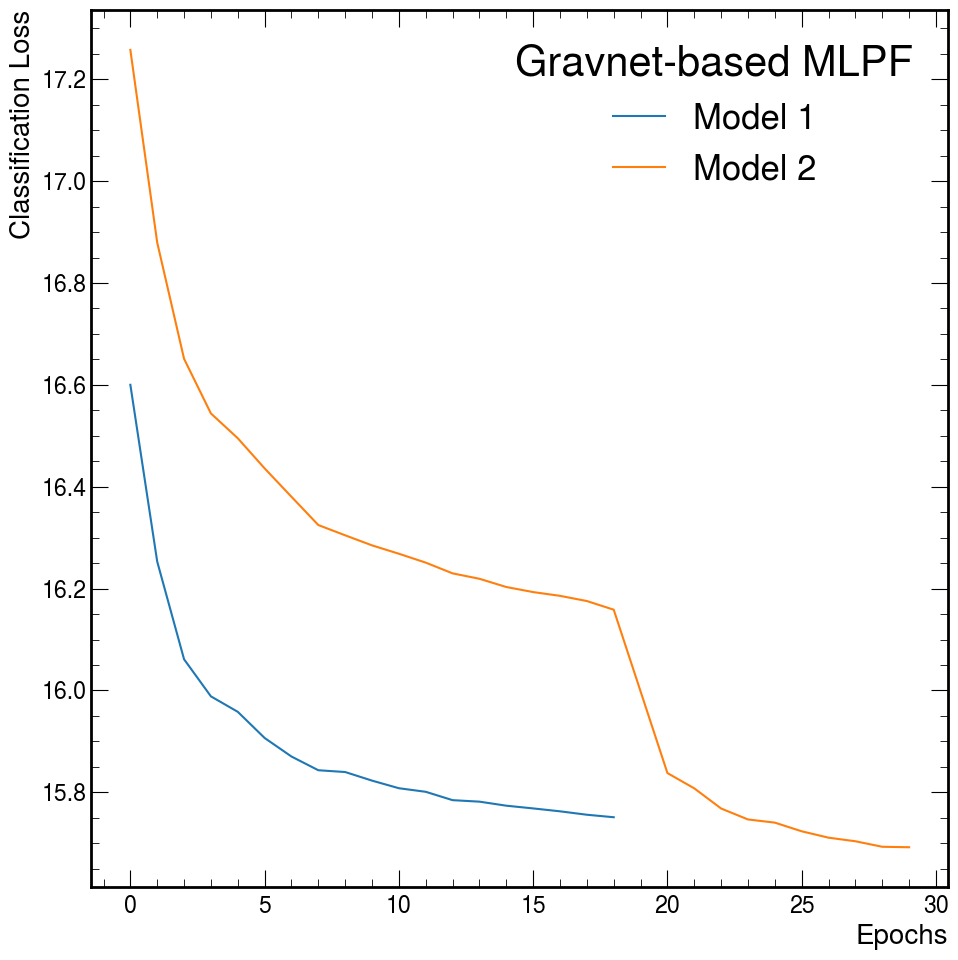

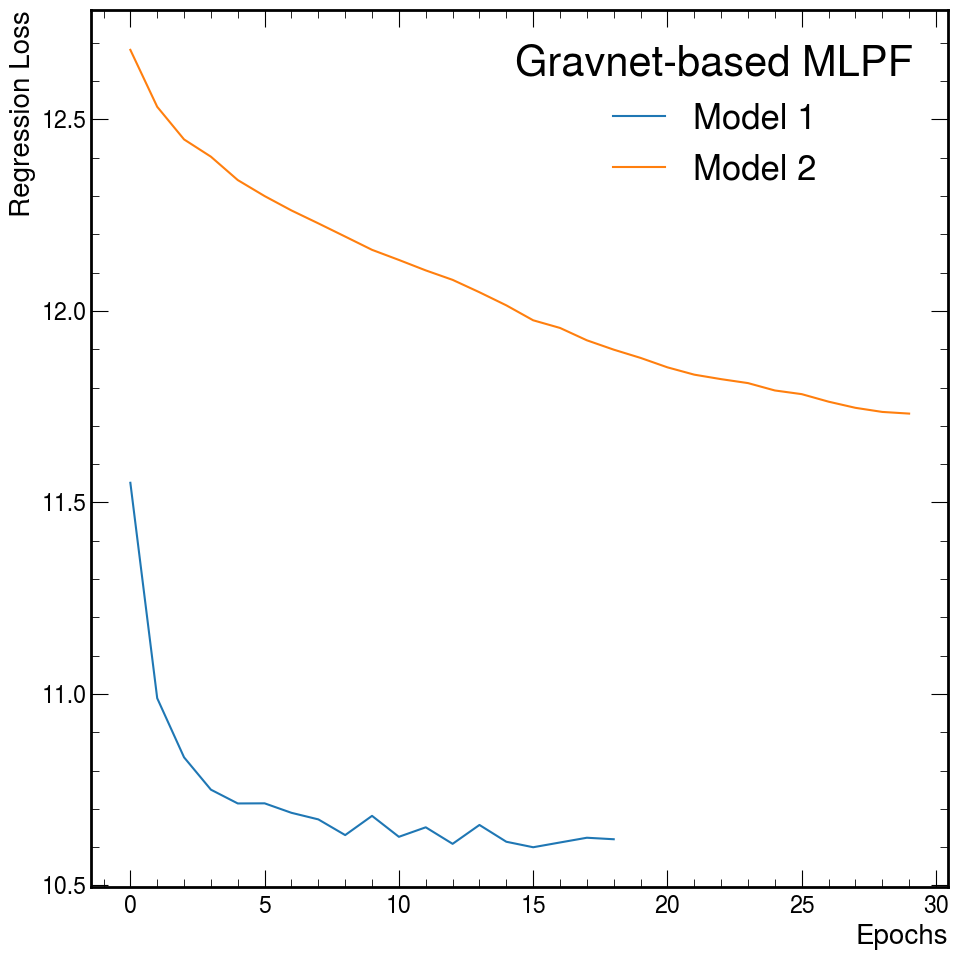

In [1003]:
for loss in ["Total", "Classification", "Regression"]:
    fig, ax = plt.subplots()

    ax.plot(losses1["valid"][loss], label="Model 1")
    ax.plot(losses2["valid"][loss], label="Model 2")
    
    ax.set_xlabel("Epochs")
    ax.set_ylabel(f"{loss} Loss")
#     ax.set_ylim(0.8 * losses["train"][loss][-1], 1.2 * losses["train"][loss][-1])
    ax.legend(title="Gravnet-based MLPF", loc="best", title_fontsize=30, fontsize=25)
    plt.tight_layout()
    plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/mlpf_loss_{loss}.pdf")

In [967]:
"checkpoint-01-28.385813.pth"[:13]

'checkpoint-01'

# soverb

In [1194]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [1195]:
samples

['DYJets',
 'WJetsLNu',
 'Data',
 'VBF',
 'VH',
 'TTbar',
 'SingleTop',
 'ggF',
 'QCD',
 'Diboson',
 'WZQQ',
 'ttH']

In [1212]:
# tagger = "ParT_finetuned"
tagger = "fj_ParT_score_finetuned"

presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    

#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) | (deta<3.5) ) & (fj_pt<300)",    
    "ggF_pt300toinf": "( (mjj<1000) | (deta<3.5) ) & (fj_pt>300)",
    
}

mass_window = [80, 160]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0


VBF = False
for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            for k, v in presel.items():
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]

                df = df.query(v)  
                
                if "High" in k:
                    if sample == "QCD":
                        df = df[df["event_weight"]<140]
                if "Medium" in k:
                    if sample == "QCD":
                        df = df[df["event_weight"]<200]
            
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
            
            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)
    
            if sample in utils.signals:
                deno_sig += df["event_weight"].sum()
                num_sig[sample] += df["event_weight"].sum()
            else:
                deno_bkg += df["event_weight"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["event_weight"].sum()
                else:
                    num_bkg["Others"] += df["event_weight"].sum() 

In [1213]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "Run2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
print("Category:", category)

print("------------------------")

print("\033[1m" + rf"s/sqrt(b): {deno_sig/math.sqrt(deno_bkg):.2f}" + '\033[0m')
print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

High purity signal region (Run2):
Category: ggF_pt300toinf
------------------------
s/sqrt(b): 1.46
------------------------
Signal: 35.44
- ttH: 7%
- VBF: 15%
- VH: 17%
- ggF: 62%
------------------------
Background: 592.34
- Others: 6%
- DYJets: 8%
- QCD: 14%
- TTbar: 26%
- WJetsLNu: 46%


In [587]:
(0.74**2 + 0.81**2 + 0.59**2)**0.5   # VBF / ggF200-300 / ggF300-450 / ggF450-inf

1.2457126474432216

# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

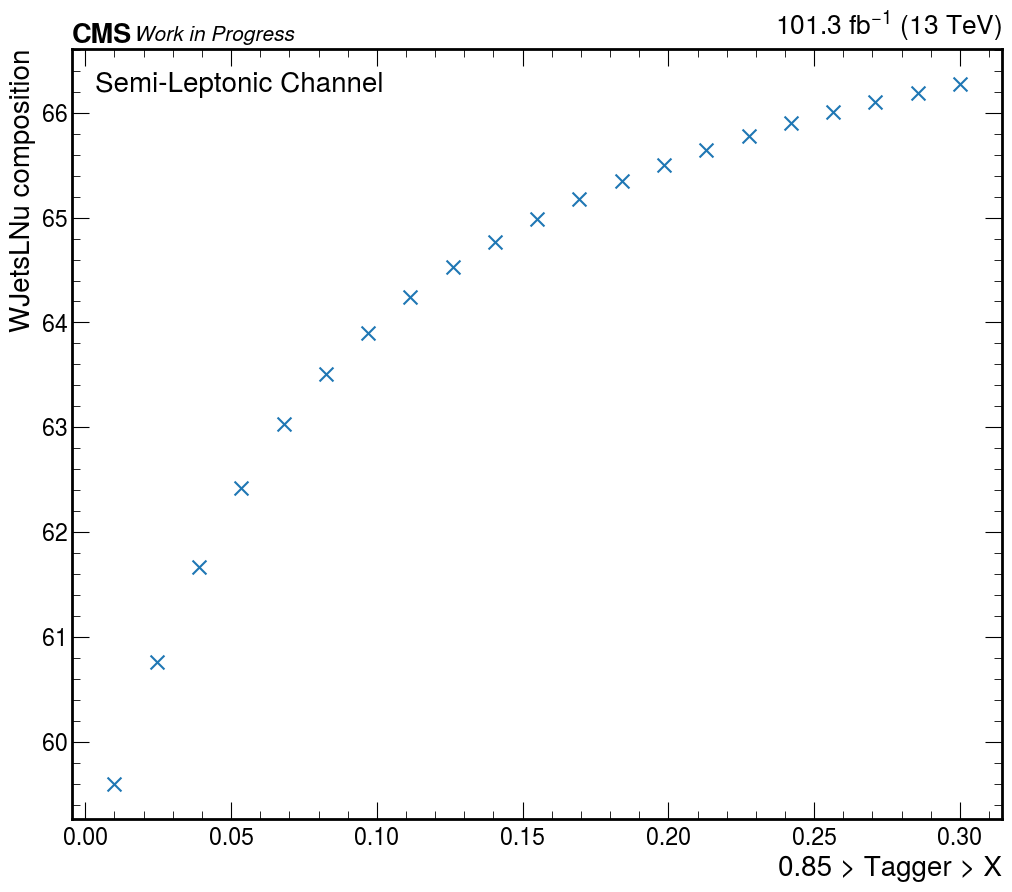

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

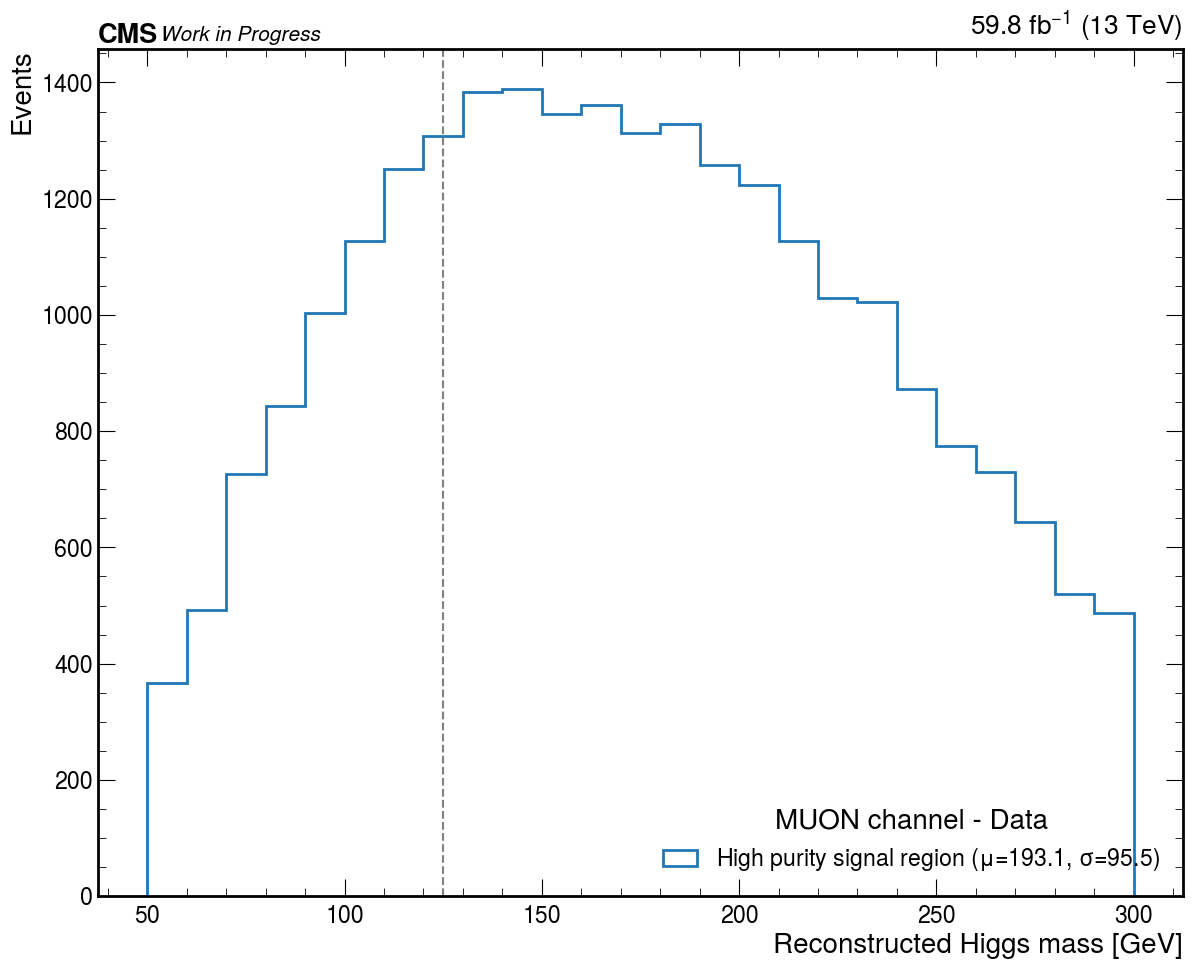

In [531]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
#     "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "Data"
channels = ["mu"]#, "ele"]
years = ["2018"]#, "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
#     w = df1["event_weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
#         weights=w,
#         density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

# Data

In [121]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [479]:
# ################### option 1
# plt.rcParams.update({"font.size": 20})
# nice_ch = {
#     "ele": "Electron",
#     "mu": "Muon",
# }

# # tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"

# region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
# #     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
# #     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
# #     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
# #     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
# #     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
# }


# ptbins = [
#     (200,300), 
#     (300,450), 
#     (450,650), 
#     (650, 2000)
# ]
# blind = True
# blind_region = (80, 160)
# mult = 10

# ch = "ele"
# years = ["2018", "2017", "2016APV", "2016"]

# fig, axs = plt.subplots(2, 2, figsize=(16,14), constrained_layout=True)

# VBF = True
# for i, ptbin in enumerate(ptbins):
#     xs, ws = {}, {}
#     for sample in ["Data", "ggF", "VBF"]:
#         xs[sample], ws[sample] = [], []
#         for year in years:
        
#             for region, sel in region_sel.items():
#                 if "QCD" in region:
#                     df = events_dict["qcd_region"][year][ch][sample]    
#                 else:
#                     df = events_dict["signal_region"][year][ch][sample]    
#                 df = df.query(sel)
                
#             df = df[(df["fj_pt"]>ptbin[0]) & (df["fj_pt"]<ptbin[1])]
            
#             if VBF:
#                 df = df[df["mjj"]>1000]
#                 df = df[df["deta"]>3.5]
#             else:
#                 df = df[df["mjj"]<1000]
#                 df = df[df["deta"]<3.5]
                
#             x = df["rec_higgs_m"]
#             if blind:
#                 x[(x>blind_region[0]) & (x<blind_region[1])] = 0   # blinding    

#             w = df[f"event_weight"]
            
#             if ((sample=="ggF") or (sample=="VBF")) and (mult!=1):
#                 w=w*mult
#                 lab=f"{mult} * {sample}"
#             else:
#                 lab=sample
                
#             xs[sample] += x.tolist()
#             ws[sample] += w.tolist() 

#         bins = 20
#         if i<2:
#             axs[0, i].hist(
#                 xs[sample], 
#                 weights=ws[sample],                    
#                 bins=np.linspace(50,240,bins),  
#                 histtype="step", 
#                 linewidth=2,
#                 label=lab,                    
#             )
#         else:
#             axs[1, i-2].hist(
#                 xs[sample],
#                 weights=ws[sample],                    
#                 bins=np.linspace(50,240,bins), 
#                 histtype="step", 
#                 linewidth=2, 
#                 label=lab,
#             )            

# lum = 0
# for year in years:
#     lum += luminosity[ch][year] / 1000.0

# for i, ax in enumerate([axs[0,0], axs[0,1], axs[1,0], axs[1,1]]):
#     lab = list([str(ptbin_) for ptbin_ in ptbins[i]])
#     for j, v in enumerate(lab):
#         if v=="2000":
#             lab[j] = "inf"
#     ax.legend(title=rf"$p_T$ $\in$ [{','.join(lab)}]", loc="upper left")
    
#     ax.set_ylabel(f"Events ({nice_ch[ch]} channel)")
#     ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
    
#     if i==3:
#         ax.set_ylim(0,4)
#         ax.set_yticks([0,1,2,3])
#     else:
#         ax.set_ylim(0)    

#     hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
#     hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# # plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/Data_ggF_{ch}_option1.pdf")        

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


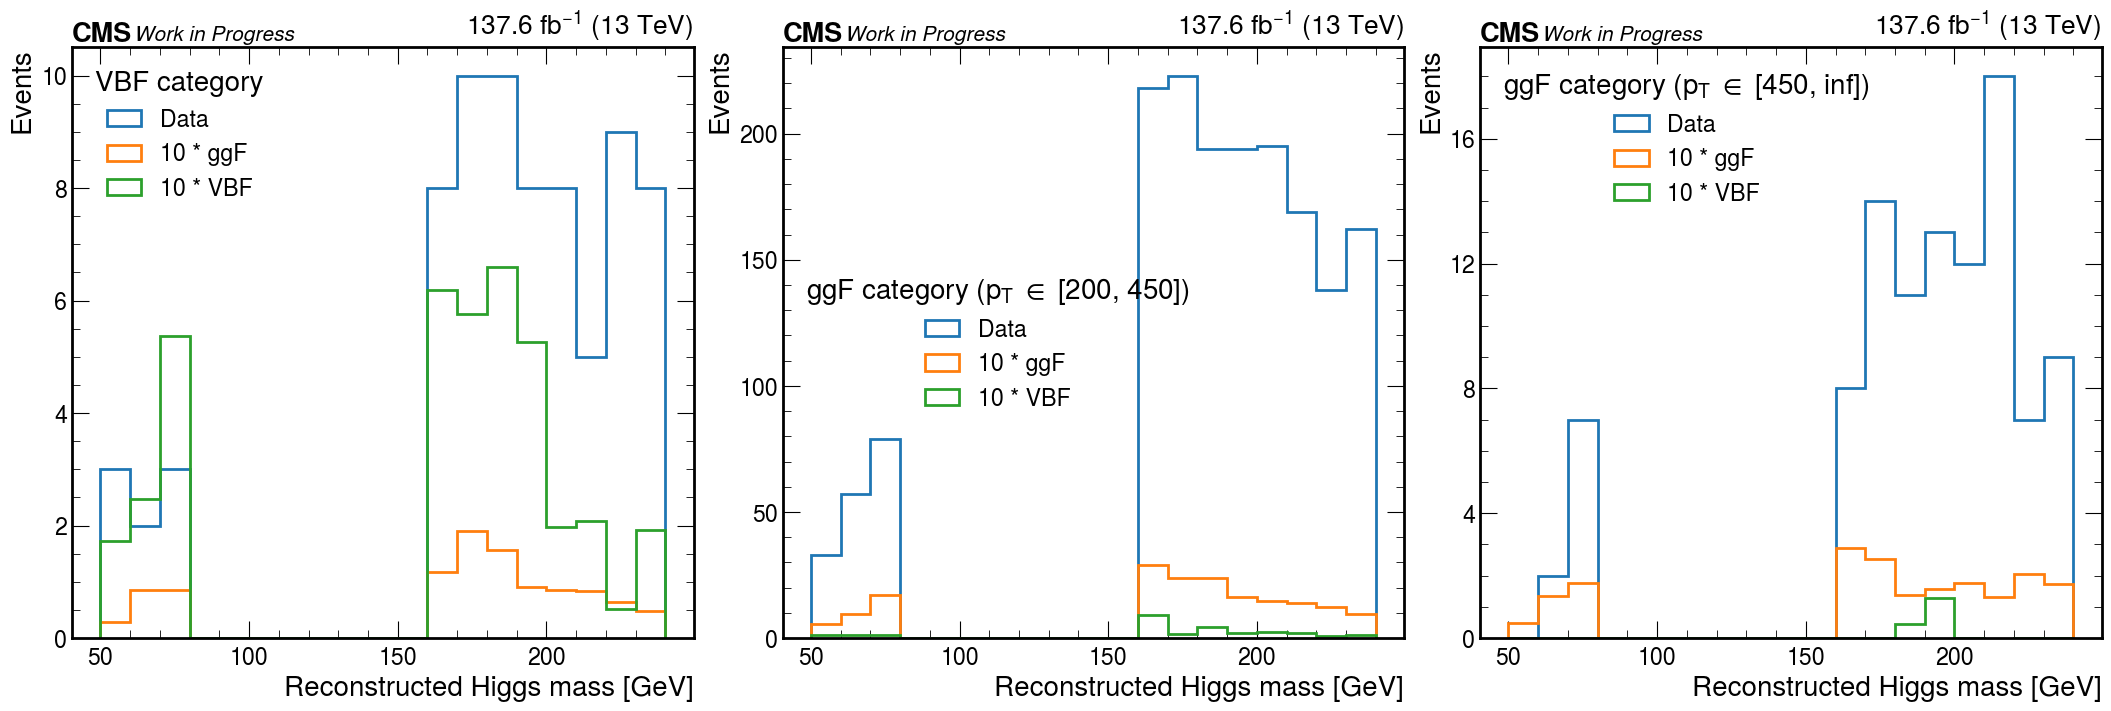

In [615]:
################### option 2
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}

categories = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
}

blind = True
blind_region = (80, 160)
mult = 10

channels = ["mu", "ele"]
years = ["2018", "2017", "2016APV", "2016"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)
    
xs, ws = {}, {}
for i, (category, sel_category) in enumerate(categories.items()):
    for sample in ["Data", "ggF", "VBF"]:
        xs[sample], ws[sample] = [], []
        for year in years:
            
            for ch in channels:
                for region, sel in region_sel.items():
                    if "QCD" in region:
                        df = events_dict["qcd_region"][year][ch][sample]    
                    else:
                        df = events_dict["signal_region"][year][ch][sample]    
                    df = df.query(sel)
                    
                df = df.query(sel_category)

                x = df["rec_higgs_m"]
#                 if blind and (sample=="Data"):
                if blind:
                    
                    x[(x>blind_region[0]) & (x<blind_region[1])] = 0   # blinding    

                w = df[f"event_weight"]

                if ((sample=="ggF") or (sample=="VBF")) and (mult!=1):
                    w=w*mult
                    lab=f"{mult} * {sample}"
                else:
                    lab=sample

                xs[sample] += x.tolist()
                ws[sample] += w.tolist()

        axs[i].hist(
            xs[sample], 
            weights=ws[sample],
            bins=np.linspace(50,240,20),  
            histtype="step", 
            linewidth=2, 
            label=lab
        )          
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
    if i==2:
        axs[i].set_yticks([0,4,8,12,16])
    
# plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/VBF_ggF_high.pdf")

In [655]:
list(range(50, 240, 20))

[50, 70, 90, 110, 130, 150, 170, 190, 210, 230]

In [ ]:

    
# plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/VBF_ggF_high.pdf")

In [622]:
var

'rec_higgs_m'

In [686]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (80, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 10)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "High purity signal region": 10,
    "Medium purity signal region": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = events_dict["signal_region"][year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if "High" in region_sel:
                        if sample == "QCD":
                            df1 = df1[df1["event_weight"]<140]
                    elif "Medium" in region_sel:
                        if sample == "QCD":
                            df1 = df1[df1["event_weight"]<200]

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


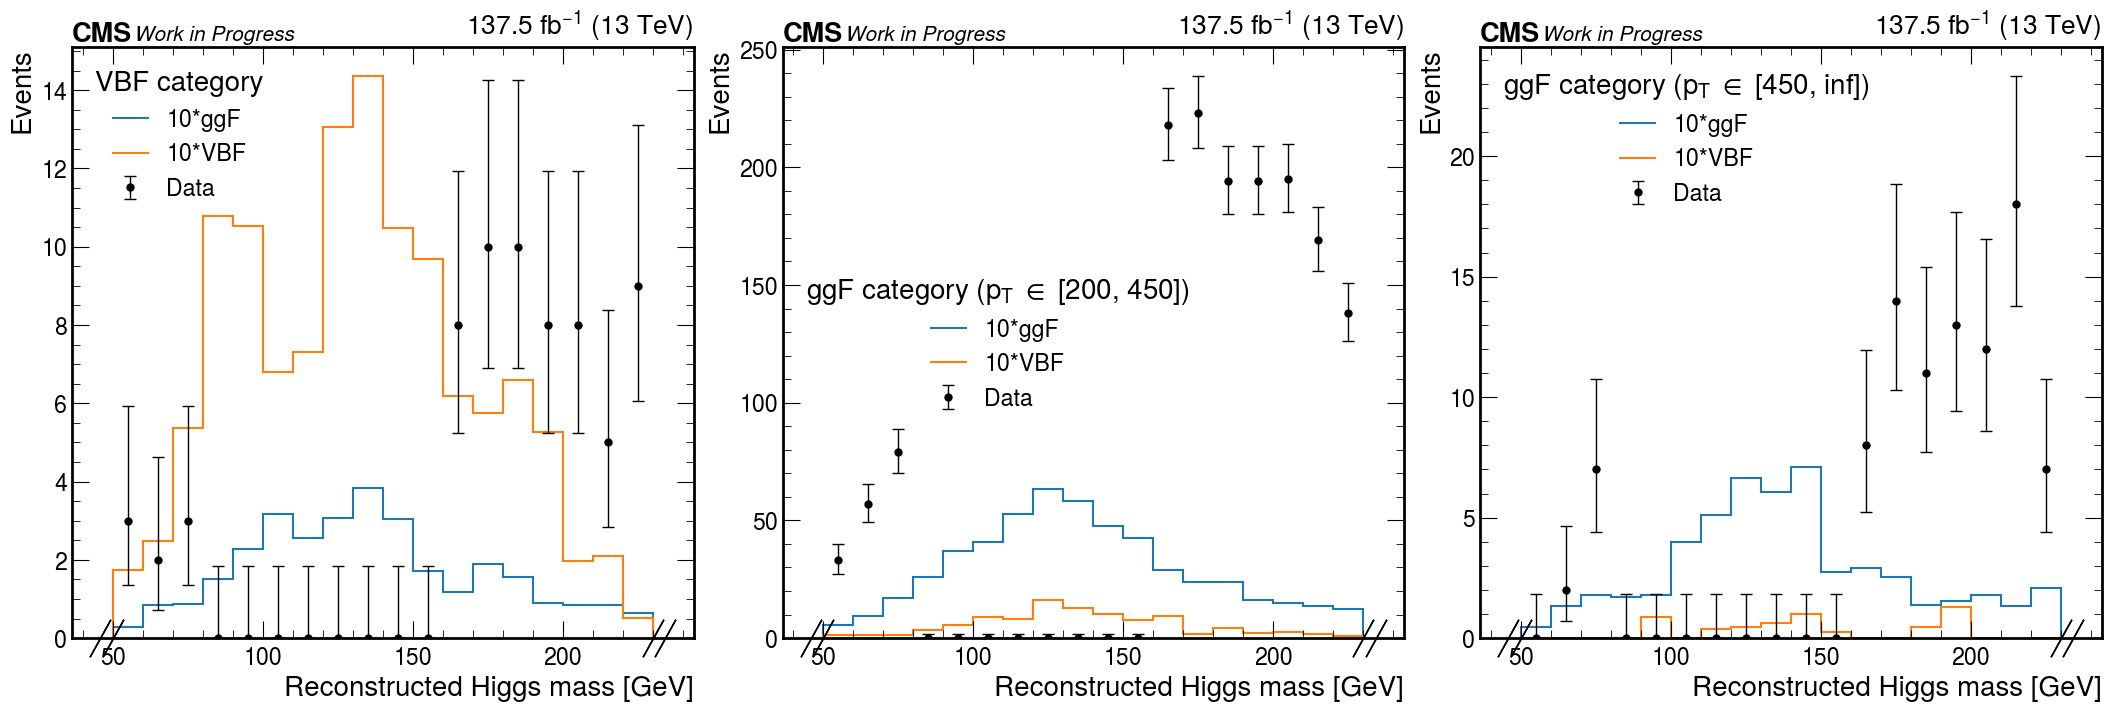

In [688]:
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)

region = "High purity signal region"
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
            
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/pt450_VBF_ggF_high_pku.pdf")

# QCD

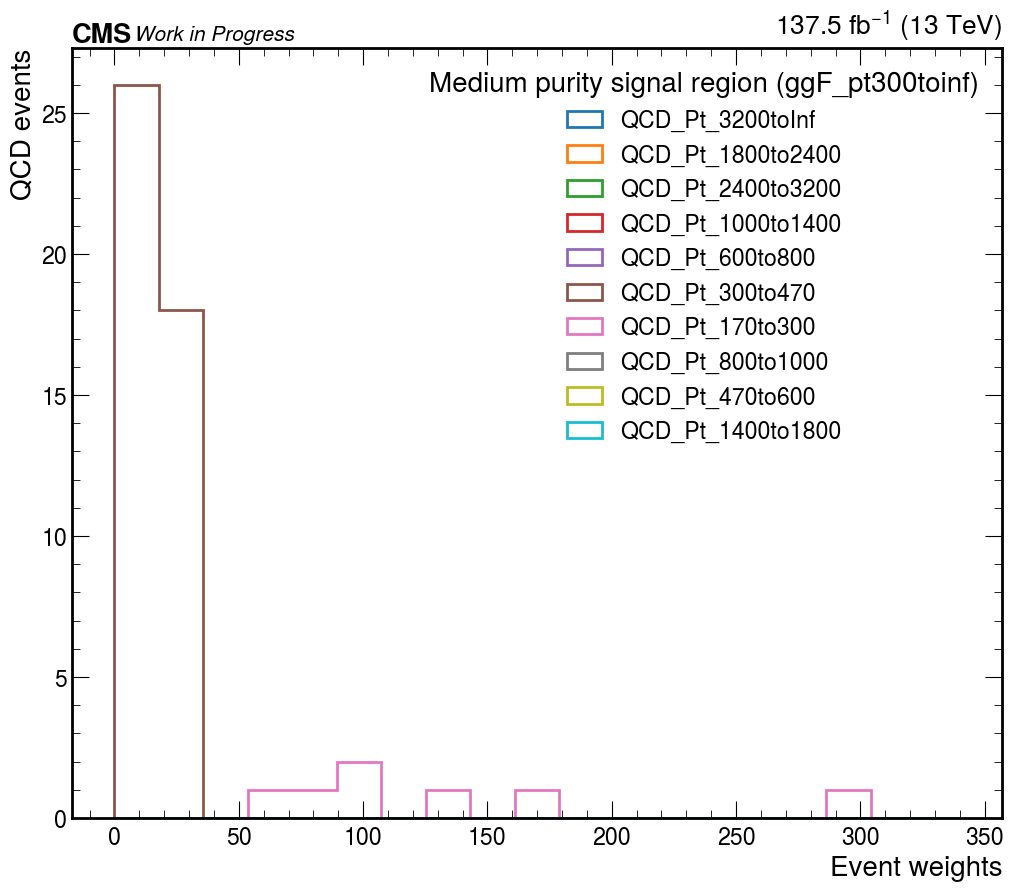

In [573]:
################### option 1
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}
categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
blind = True
blind_region = (80, 160)
mult = 10

years = ["2018", "2017", "2016APV", "2016"]
sample="QCD"

fig, ax = plt.subplots(figsize=(12,10))    

ws = {}

for sample in events_dict2["signal_region"]["2017"][ch]:
    ws[sample] = []
    for year in years:
        for ch in ["ele", "mu"]:
            try:
                df = events_dict2["signal_region"][year][ch][sample]
            except:
                continue

            for region, sel in region_sel.items():
                df = df.query(sel)

            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)

            w = df[f"event_weight"]
            ws[sample] += w.tolist() 
    
    ws[sample] = np.array(ws[sample])
    ws[sample] = ws[sample][ws[sample]>10]

    bins = 20
    ax.hist(
        ws[sample],
        bins=np.linspace(0,340,bins), 
        histtype="step", 
        linewidth=2, 
        label=sample
    )
#     break

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0

ax.legend(title=f"{region} ({category})", loc="upper right")

ax.set_ylabel(f"QCD events")
ax.set_xlabel(f"Event weights")  
ax.set_ylim(0)

hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/WWW_QCD_weights_medium_{category}.pdf")        

In [740]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", category="VBF", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1, "categories": category}],
        ax=ax,
#         histtype="step",
        histtype="errorbar",        
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2, "categories": category}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1, "categories": category}].values()
    tot_val = h[{"region": region2, "categories": category}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()


    hep.histplot(
        data_val / tot_val,
        h[{"region": region1, "categories": category}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=category)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    
    
    ax.set_ylabel(f"Normalized {sample} events")
    
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}.pdf")   

In [741]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

categories_sel = {
    "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
    "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
            
channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

sample = "QCD"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.StrCategory([], name="categories", growth=True),            
            hist2.axis.Variable(
                list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
            )
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for region, region_sel in presel.items():
                for category, category_sel in categories_sel.items():
                
                    if "QCD control region" in region:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]

                    if "High" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]
                    elif "Medium" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<200]

                    df = df.query(region_sel)
                    df = df.query(category_sel)

                    hists[var].fill(
                        region=region,
                        categories=category,
                        mass_observable=df[var],
                        weight=df["event_weight"],
                    )     

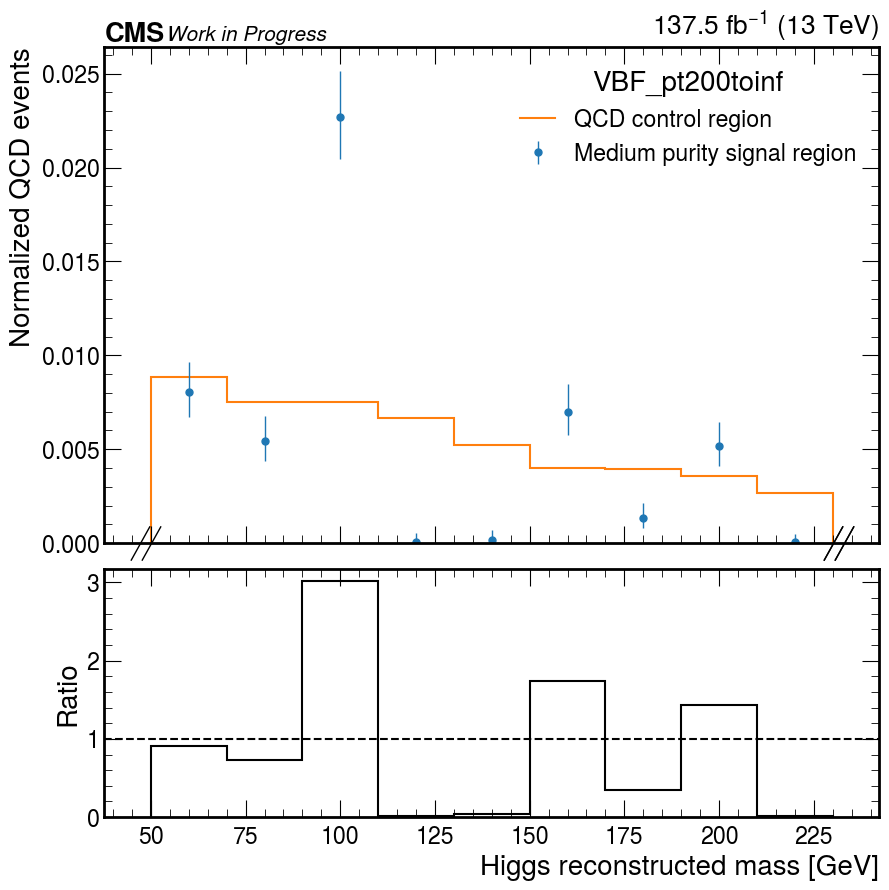

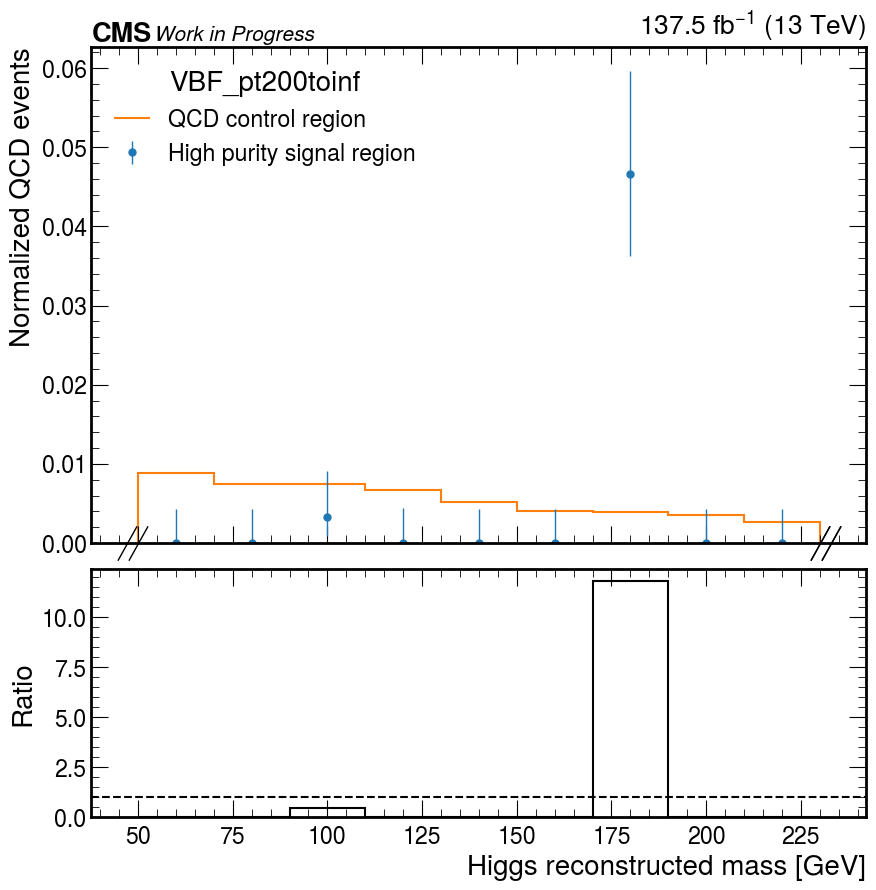

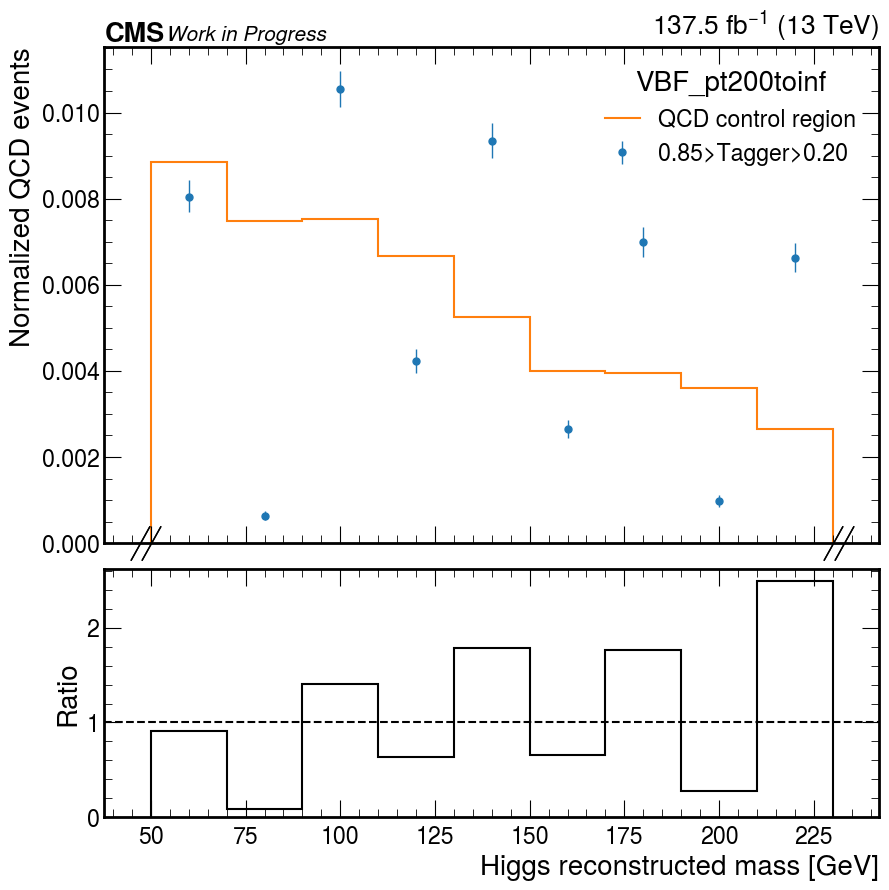

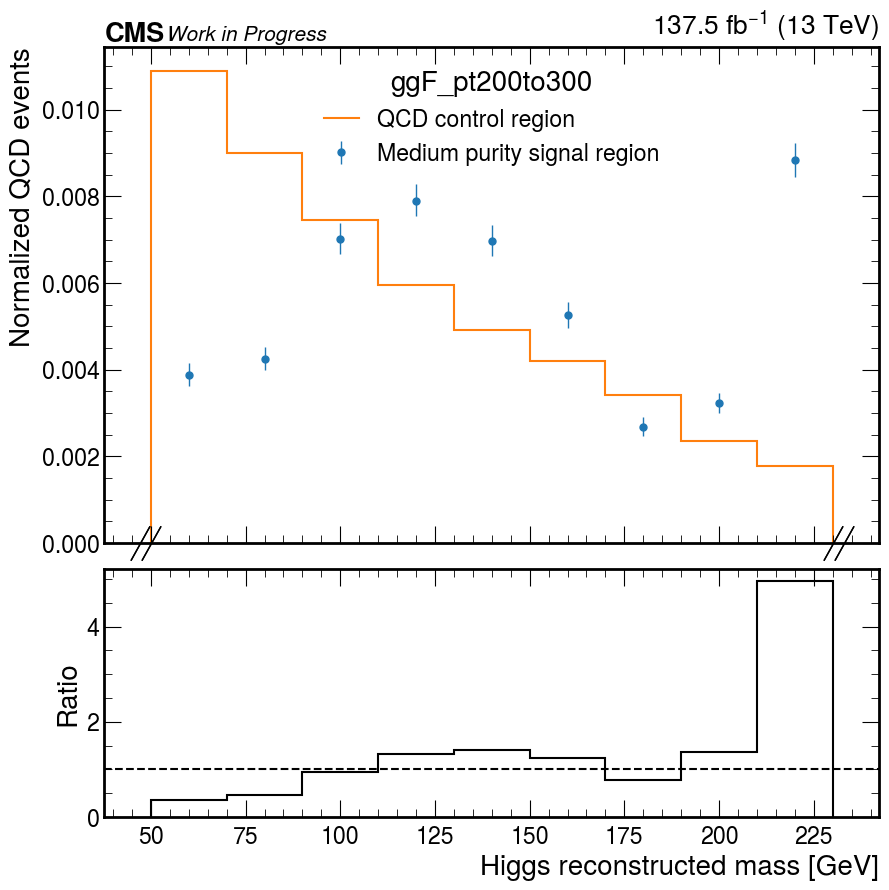

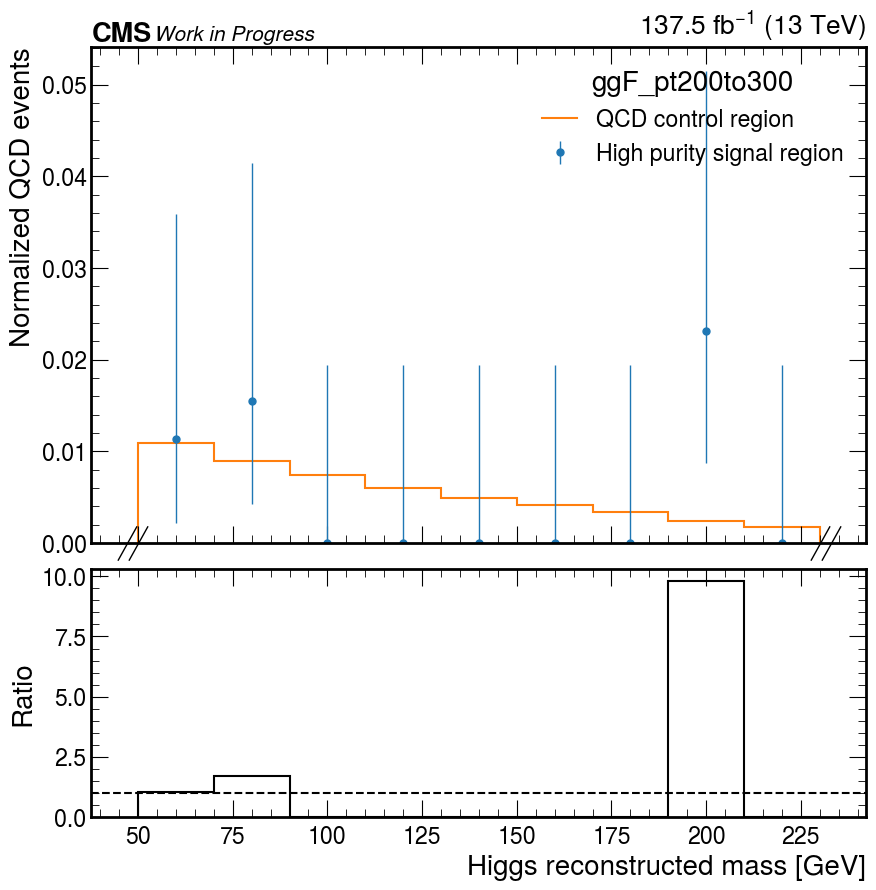

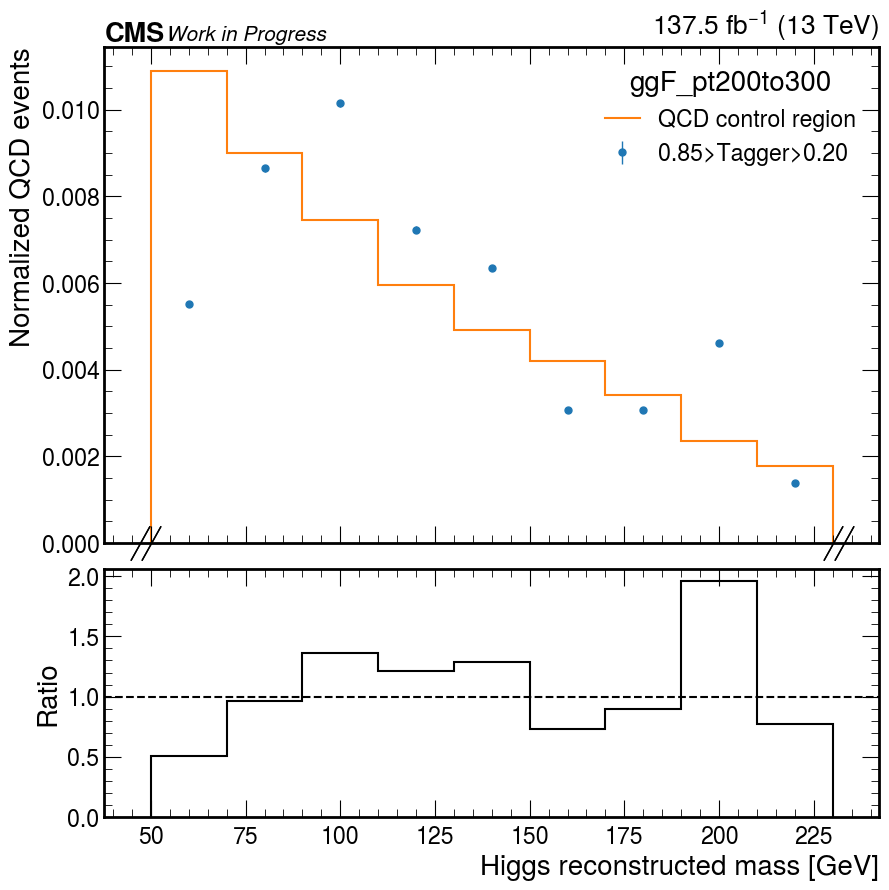

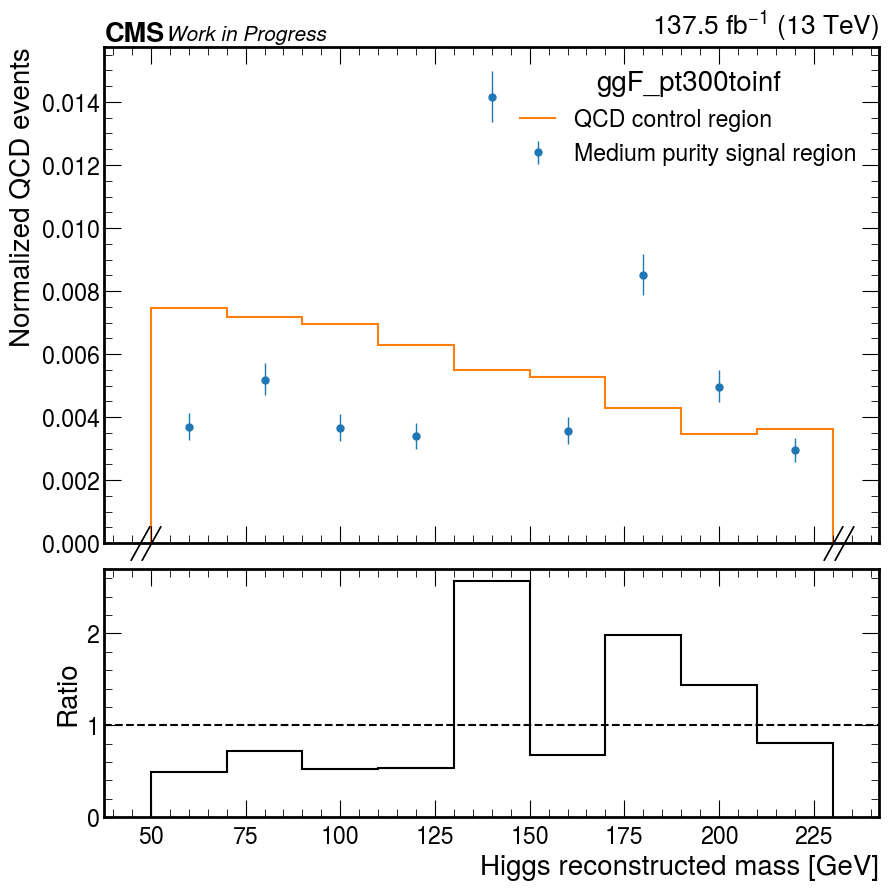

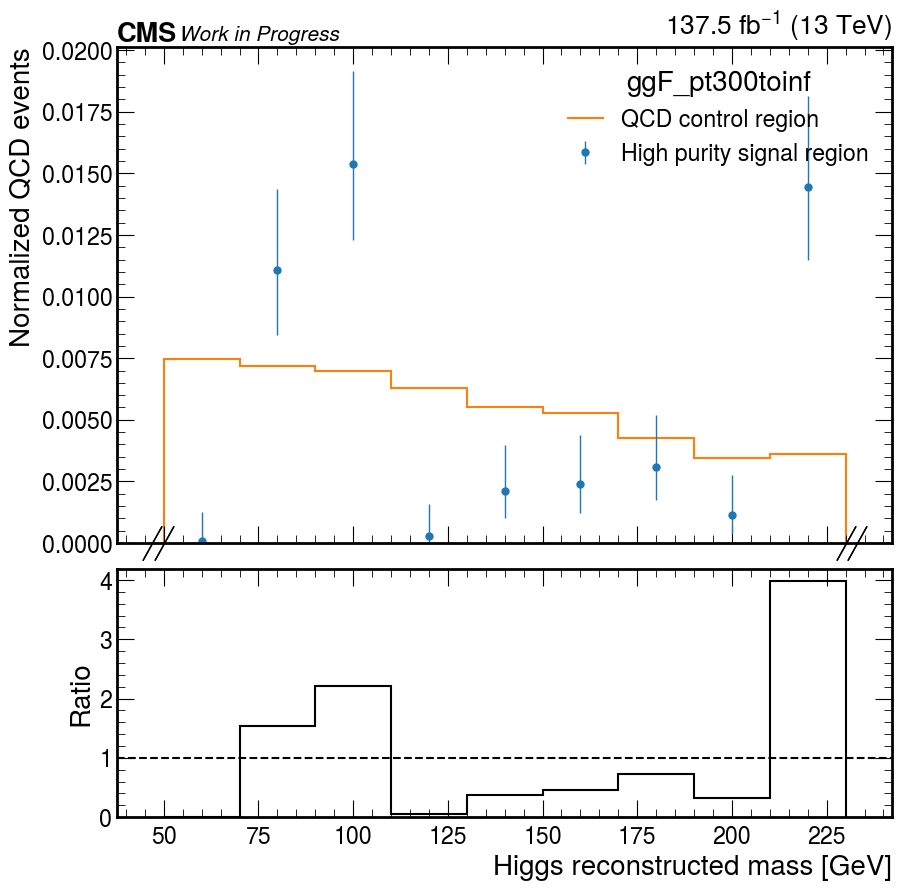

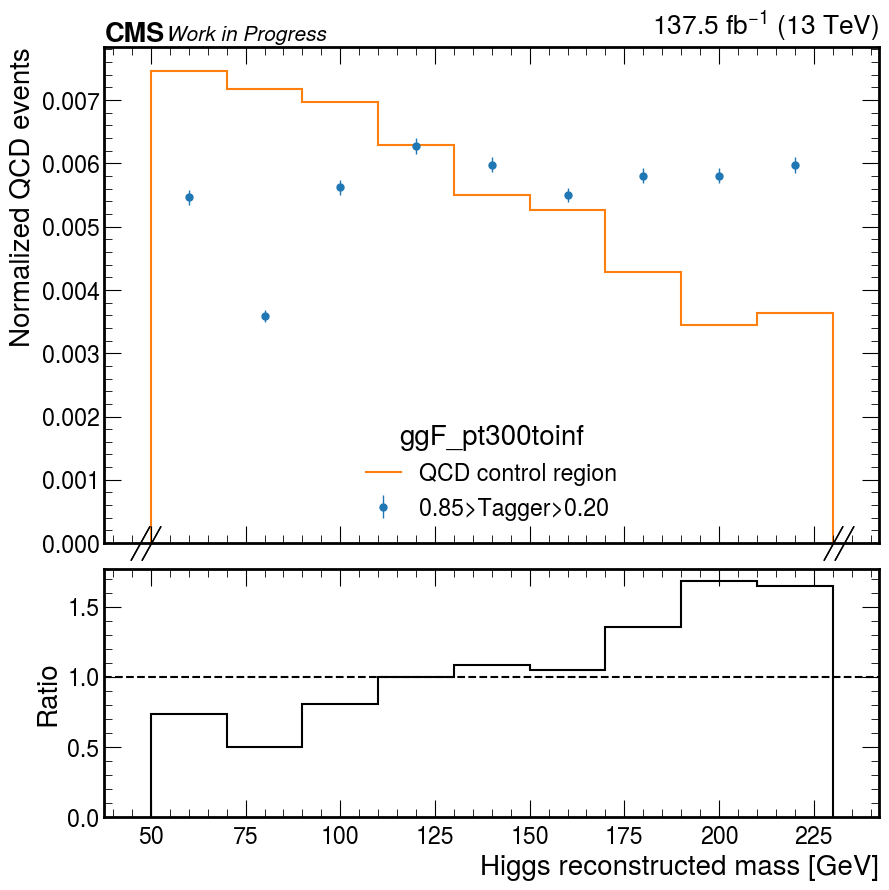

In [754]:
region_dic = {
    "Medium purity signal region": "medium",
    "High purity signal region": "high",
    "0.85>Tagger>0.20": "low",    
}

for category in ["VBF_pt200toinf", "ggF_pt200to300", "ggF_pt300toinf"]:
    
    for region in region_dic:
        plot_ratio(hists["rec_higgs_m"], 
                   years, 
                   region1 = region,
                   region2 = "QCD control region",
                   sample=sample,
                   category=category,
                   tag=f"{category}_{region_dic[region]}"
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

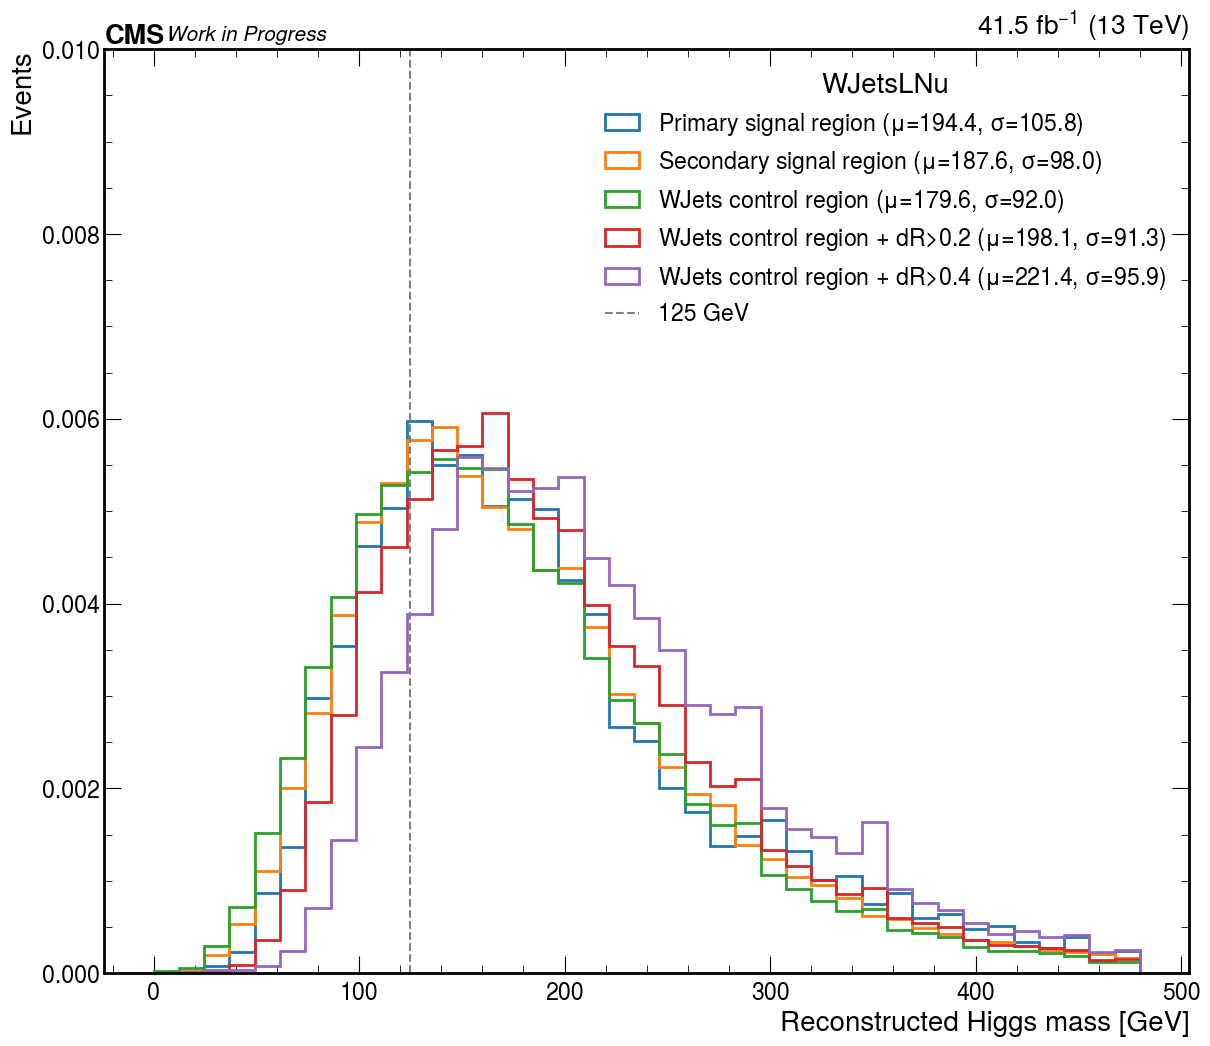

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  

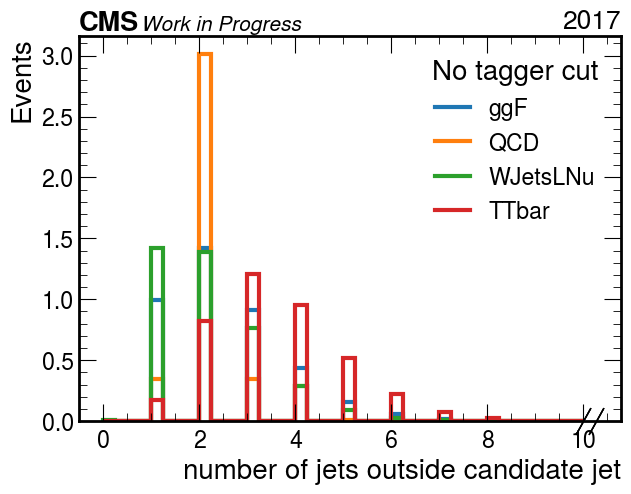

In [20]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
     "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "nj"
# var = "met_fj_dphi"
# var = "lep_met_mt"
# var = "mjj"


h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(7, 5))

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            df = events_dict[year][ch][sample]

            # tagger cut
    #         df = df[df["inclusive_score"]>0.9]

    #         df = df[df["lep_fj_dr"]>0.03]        
            df = df[df["n_bjets_M"]<2]
    #         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

            h.fill(
                samples=sample,
                var=df[var],
                weight=df["event_weight"]
            )

for sample in samples_to_plot:
    if sample in utils.sig_labels:
        lab = utils.sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"No tagger cut")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

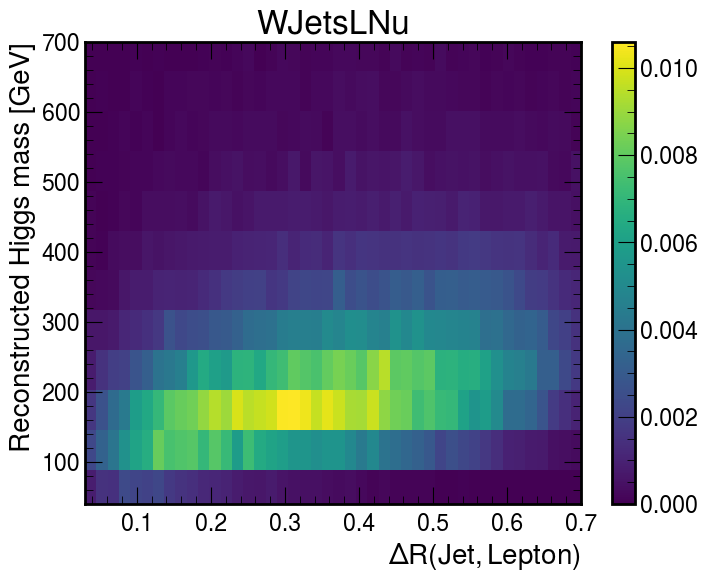

In [16]:
samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

var1 = "lep_fj_dr"
var2 = "rec_higgs_m"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))

for sample in samples_to_plot:
    for year in years:
        for i, ch in enumerate(channels):
            df = events_dict[year][ch][sample]

            df = df[df["inclusive_score"]>0.99]
            df = df[df["fj_pt"]>220]

            if i==0:
                dff = df
            else:
                dff = pd.concat([dff, df])


    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[50,50]
          )

ax.set_xlim(0.03,0.7)
ax.set_ylim(40, 700)
ax.set_xlabel(r"$\Delta R(Jet,Lepton)}$");
ax.set_ylabel(r"Reconstructed Higgs mass [GeV]");
ax.set_title(sample)
plt.colorbar()

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
plt.savefig(f"{save_as}/2d-{var1}-{var2}-{sample}.pdf", bbox_inches='tight')